# Image Scene Description using Image Embeddings

This notebook demonstates end-to-end process of generating image embeddings from Flickr8k dataset using InceptionV3 and generate captions using LSTM.

In [79]:
import numpy as np 
import pandas as pd
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Concatenate, Flatten, Softmax
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import pad_sequences
import nltk
import os

## Prepare data

In [4]:
image_path = '../input/flickr8k/Images'

In [5]:
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [6]:
data.size

80910

In [7]:
data_d = {}
for ind in data.index:
    data_d[image_path+'/'+ data['image'][ind]] = list()
    
for ind in data.index:
    data_d[image_path+'/'+ data['image'][ind]].append(data['caption'][ind])

In [8]:
list(data_d.items())[0]

('../input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'])

In [9]:
len(data_d)

8091

In [10]:
train_d = dict(list(data_d.items())[0:6473])
val_d = dict(list(data_d.items())[6473:7282])
test_d = dict(list(data_d.items())[7282:])

In [11]:
len(train_d)+len(val_d)+len(test_d)

8091

In [12]:
len(val_d)

809

In [13]:
len(test_d)

809

## Convert PIL images to Numpy array and analyze images with captions

In [14]:
from textwrap import wrap
from tensorflow.keras.utils import load_img, img_to_array

In [15]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"{image_path}/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

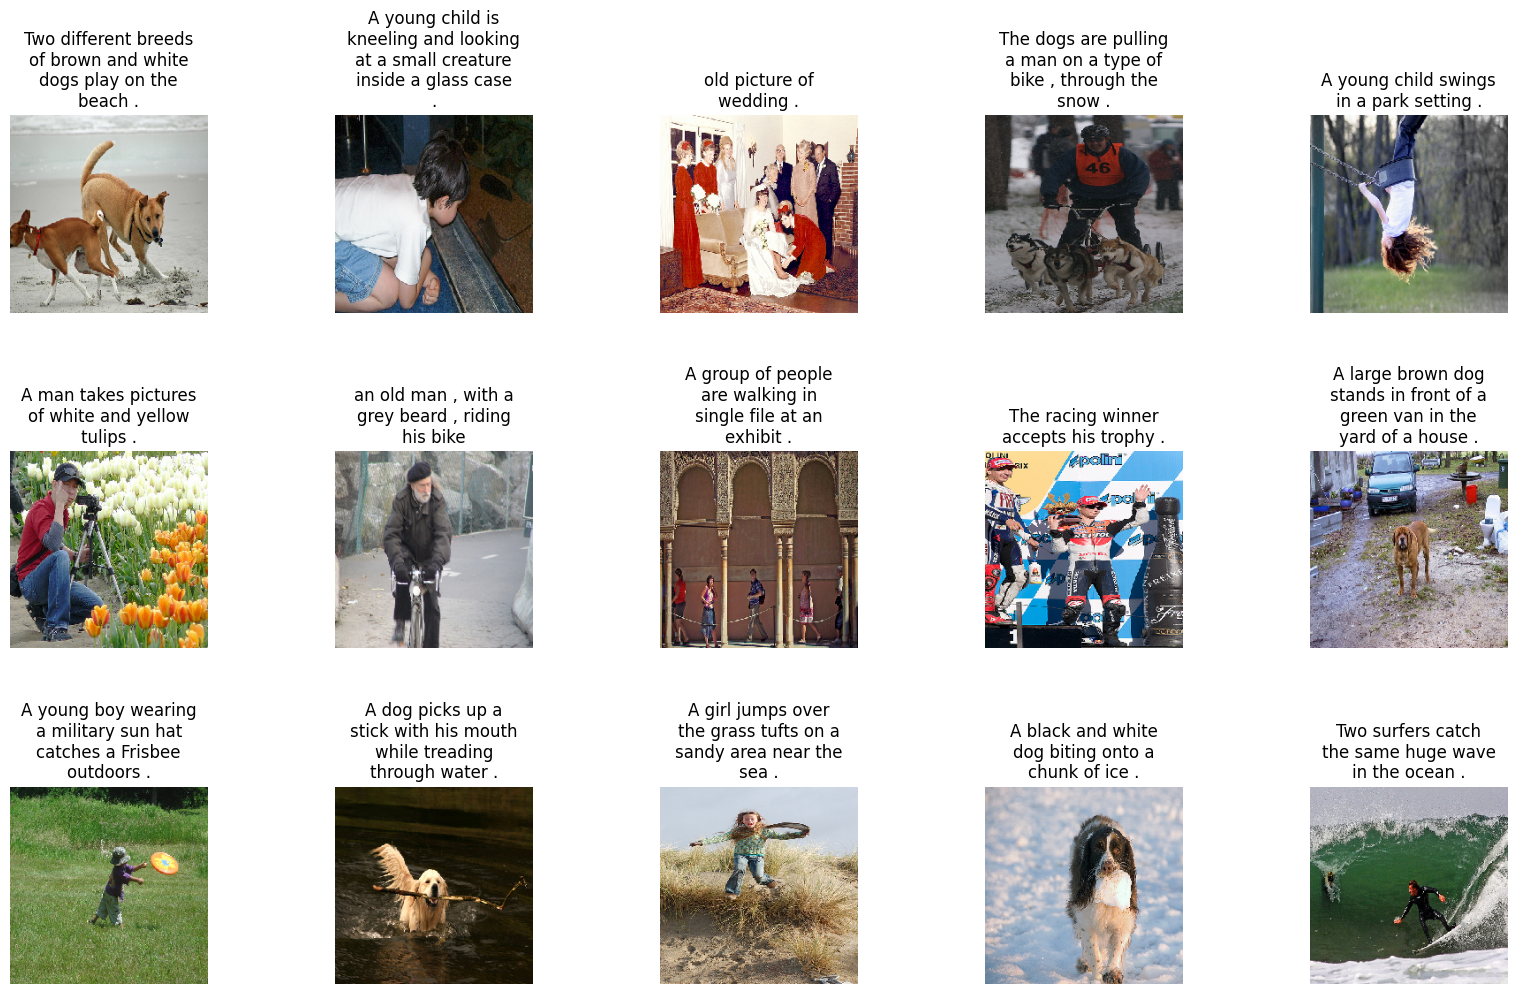

In [16]:
display_images(data.sample(15))

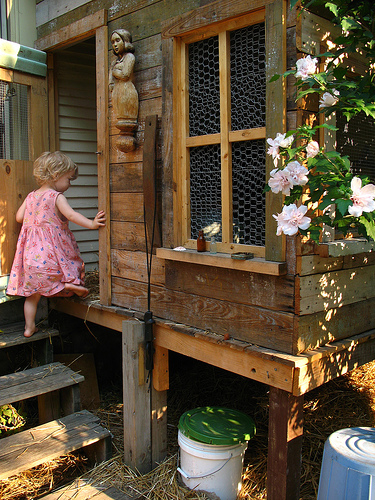

In [17]:
Image.open(list(train_d.keys())[0])

## Processing all images

In [18]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [19]:
def preprocess(image_path):
    img = load_img(image_path, color_mode='rgb', target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

## Generating Embeddings

Get pre-tained InceptionV3 model on imagenet dataset

In [20]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 5s 0us/step


Modifying the model to get embeddings as output instead of prediction (-2 layers)

In [21]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [22]:
test_zero = model_new.predict(preprocess(list(train_d.keys())[0]))

1/1 [==============================] - 6s 6s/step


In [23]:
test_zero.shape

(1, 2048)

In [24]:
def encode(img_path):
    image = preprocess(img_path)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [25]:
encoding_train = {}
for img in tqdm(list(train_d.keys())):
    encoding_train[img] = encode(img)

  0%|          | 0/6473 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 2/6473 [00:00<09:20, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 4/6473 [00:00<09:24, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 6/6473 [00:00<09:52, 10.91it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 8/6473 [00:00<09:49, 10.97it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 10/6473 [00:00<09:27, 11.38it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 12/6473 [00:01<09:36, 11.21it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 14/6473 [00:01<09:55, 10.85it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 16/6473 [00:01<09:51, 10.91it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 18/6473 [00:01<09:45, 11.02it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 20/6473 [00:01<09:43, 11.07it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 22/6473 [00:01<09:24, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 24/6473 [00:02<09:18, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 26/6473 [00:02<09:10, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 28/6473 [00:02<09:09, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 30/6473 [00:02<09:20, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 32/6473 [00:02<09:20, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 34/6473 [00:02<09:17, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 36/6473 [00:03<09:17, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 38/6473 [00:03<09:22, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 40/6473 [00:03<09:17, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 42/6473 [00:03<09:13, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 44/6473 [00:03<09:08, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 46/6473 [00:04<09:11, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 48/6473 [00:04<09:44, 10.99it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 50/6473 [00:04<09:31, 11.23it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 52/6473 [00:04<09:34, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 54/6473 [00:04<09:22, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 56/6473 [00:04<09:28, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 58/6473 [00:05<09:35, 11.15it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 60/6473 [00:05<09:30, 11.25it/s]

1/1 [==============================] - 0s 61ms/step


  1%|          | 62/6473 [00:05<10:41, 10.00it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 64/6473 [00:05<10:24, 10.26it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 66/6473 [00:05<09:58, 10.70it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 68/6473 [00:06<09:26, 11.31it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 70/6473 [00:06<09:27, 11.28it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 72/6473 [00:06<09:29, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 74/6473 [00:06<09:32, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 76/6473 [00:06<09:21, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 78/6473 [00:06<09:22, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 80/6473 [00:07<09:16, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 82/6473 [00:07<08:55, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 84/6473 [00:07<09:07, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 86/6473 [00:07<09:05, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 88/6473 [00:07<09:02, 11.78it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 90/6473 [00:07<09:09, 11.62it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 92/6473 [00:08<09:12, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 94/6473 [00:08<09:03, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 96/6473 [00:08<09:04, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 98/6473 [00:08<09:03, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 100/6473 [00:08<08:58, 11.83it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 102/6473 [00:08<09:02, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 104/6473 [00:09<08:59, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 106/6473 [00:09<08:58, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 108/6473 [00:09<09:05, 11.66it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 110/6473 [00:09<09:19, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 112/6473 [00:09<09:24, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 114/6473 [00:10<09:17, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 116/6473 [00:10<09:11, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 118/6473 [00:10<09:05, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 120/6473 [00:10<09:09, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 122/6473 [00:10<08:58, 11.79it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 124/6473 [00:10<10:17, 10.29it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 126/6473 [00:11<11:31,  9.18it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 127/6473 [00:11<11:47,  8.97it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 128/6473 [00:11<11:46,  8.98it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 129/6473 [00:11<11:45,  9.00it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 130/6473 [00:11<11:42,  9.04it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 131/6473 [00:11<12:40,  8.34it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 132/6473 [00:11<12:20,  8.56it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 133/6473 [00:12<12:04,  8.75it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 135/6473 [00:12<10:39,  9.91it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 137/6473 [00:12<10:11, 10.35it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 139/6473 [00:12<09:38, 10.94it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 141/6473 [00:12<09:21, 11.27it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 143/6473 [00:12<09:13, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 145/6473 [00:13<09:23, 11.23it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 147/6473 [00:13<09:17, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 149/6473 [00:13<09:17, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 151/6473 [00:13<09:13, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 153/6473 [00:13<09:10, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 155/6473 [00:13<09:13, 11.42it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 157/6473 [00:14<09:11, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 159/6473 [00:14<09:08, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 161/6473 [00:14<09:15, 11.35it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 163/6473 [00:14<09:24, 11.18it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 165/6473 [00:14<09:20, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 167/6473 [00:14<09:12, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 169/6473 [00:15<09:06, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 171/6473 [00:15<09:02, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 173/6473 [00:15<09:18, 11.29it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 175/6473 [00:15<09:04, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 177/6473 [00:15<08:59, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 179/6473 [00:16<08:49, 11.88it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 181/6473 [00:16<08:58, 11.69it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 183/6473 [00:16<09:08, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 185/6473 [00:16<10:38,  9.85it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 187/6473 [00:16<10:01, 10.44it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 189/6473 [00:16<09:41, 10.81it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 191/6473 [00:17<09:36, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 193/6473 [00:17<09:15, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 195/6473 [00:17<09:06, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 197/6473 [00:17<08:58, 11.66it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 199/6473 [00:17<09:11, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 201/6473 [00:18<09:07, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 203/6473 [00:18<09:03, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 205/6473 [00:18<08:59, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 207/6473 [00:18<09:02, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 209/6473 [00:18<09:07, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 211/6473 [00:18<08:59, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 213/6473 [00:19<08:58, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 215/6473 [00:19<08:56, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 217/6473 [00:19<09:04, 11.49it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 219/6473 [00:19<09:02, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 221/6473 [00:19<09:08, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 223/6473 [00:19<09:01, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 225/6473 [00:20<08:58, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 227/6473 [00:20<08:56, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 229/6473 [00:20<08:50, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 231/6473 [00:20<08:48, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 233/6473 [00:20<08:50, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 235/6473 [00:20<08:56, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 237/6473 [00:21<08:50, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 239/6473 [00:21<08:55, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 241/6473 [00:21<08:54, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 243/6473 [00:21<09:00, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 245/6473 [00:21<08:55, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 247/6473 [00:21<08:56, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 249/6473 [00:22<08:55, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 251/6473 [00:22<08:56, 11.61it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 253/6473 [00:22<09:03, 11.45it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 255/6473 [00:22<09:05, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 257/6473 [00:22<09:04, 11.42it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 259/6473 [00:23<09:04, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 261/6473 [00:23<09:05, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 263/6473 [00:23<08:57, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 265/6473 [00:23<08:51, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 267/6473 [00:23<08:43, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 269/6473 [00:23<08:38, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 271/6473 [00:24<08:49, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 273/6473 [00:24<08:59, 11.50it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 275/6473 [00:24<08:54, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 277/6473 [00:24<09:04, 11.37it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 279/6473 [00:24<09:06, 11.33it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 281/6473 [00:24<08:58, 11.50it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 283/6473 [00:25<08:42, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 285/6473 [00:25<08:43, 11.82it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 287/6473 [00:25<08:49, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 289/6473 [00:25<08:50, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 291/6473 [00:25<08:49, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 293/6473 [00:25<08:48, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 295/6473 [00:26<08:56, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 297/6473 [00:26<09:03, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 299/6473 [00:26<08:59, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 301/6473 [00:26<08:56, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 303/6473 [00:26<08:48, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 305/6473 [00:26<08:45, 11.73it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 307/6473 [00:27<08:54, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 309/6473 [00:27<08:55, 11.50it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 311/6473 [00:27<10:28,  9.80it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 313/6473 [00:27<10:04, 10.19it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 315/6473 [00:27<09:51, 10.40it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 317/6473 [00:28<09:34, 10.71it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 319/6473 [00:28<09:16, 11.05it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 321/6473 [00:28<09:00, 11.39it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 323/6473 [00:28<08:46, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 325/6473 [00:28<08:55, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 327/6473 [00:28<08:47, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 329/6473 [00:29<08:44, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 331/6473 [00:29<08:46, 11.66it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 333/6473 [00:29<08:52, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 335/6473 [00:29<08:50, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 337/6473 [00:29<08:36, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 339/6473 [00:29<08:29, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 341/6473 [00:30<08:22, 12.20it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 343/6473 [00:30<08:35, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 345/6473 [00:30<08:36, 11.88it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 347/6473 [00:30<08:30, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 349/6473 [00:30<08:36, 11.86it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 351/6473 [00:31<08:41, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 353/6473 [00:31<08:47, 11.59it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 355/6473 [00:31<08:51, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 357/6473 [00:31<08:50, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 359/6473 [00:31<08:42, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 361/6473 [00:31<09:16, 10.98it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 363/6473 [00:32<08:57, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 365/6473 [00:32<08:49, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 367/6473 [00:32<08:43, 11.65it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 369/6473 [00:32<08:52, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 371/6473 [00:32<08:59, 11.30it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 373/6473 [00:32<08:53, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 375/6473 [00:33<08:47, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 377/6473 [00:33<08:45, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 379/6473 [00:33<08:46, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 381/6473 [00:33<08:44, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 383/6473 [00:33<08:40, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 385/6473 [00:33<08:37, 11.75it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 387/6473 [00:34<08:46, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 389/6473 [00:34<08:55, 11.36it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 391/6473 [00:34<09:14, 10.96it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 393/6473 [00:34<09:04, 11.16it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 395/6473 [00:34<08:56, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 397/6473 [00:35<08:52, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 399/6473 [00:35<08:45, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 401/6473 [00:35<08:49, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 403/6473 [00:35<08:43, 11.60it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 405/6473 [00:36<14:02,  7.20it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 407/6473 [00:36<12:43,  7.94it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 409/6473 [00:36<11:47,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 411/6473 [00:36<11:02,  9.14it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 413/6473 [00:36<10:31,  9.60it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 415/6473 [00:37<10:22,  9.74it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 417/6473 [00:37<10:03, 10.03it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 419/6473 [00:37<10:11,  9.90it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 421/6473 [00:37<09:54, 10.18it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 423/6473 [00:37<09:54, 10.18it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 425/6473 [00:37<09:41, 10.40it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 427/6473 [00:38<09:31, 10.59it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 429/6473 [00:38<09:21, 10.75it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 431/6473 [00:38<10:49,  9.30it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 433/6473 [00:38<10:20,  9.73it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 435/6473 [00:38<09:57, 10.11it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 437/6473 [00:39<09:42, 10.37it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 439/6473 [00:39<09:30, 10.57it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 441/6473 [00:39<09:26, 10.66it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 443/6473 [00:39<09:17, 10.81it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 445/6473 [00:39<09:11, 10.93it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 447/6473 [00:40<09:06, 11.03it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 449/6473 [00:40<09:13, 10.88it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 451/6473 [00:40<09:04, 11.06it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 453/6473 [00:40<08:50, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 455/6473 [00:40<08:49, 11.37it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 457/6473 [00:40<08:56, 11.22it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 459/6473 [00:41<08:51, 11.32it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 461/6473 [00:41<08:44, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 463/6473 [00:41<08:36, 11.64it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 465/6473 [00:41<08:49, 11.35it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 467/6473 [00:41<08:59, 11.12it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 469/6473 [00:42<08:54, 11.24it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 471/6473 [00:42<08:47, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 473/6473 [00:42<08:43, 11.45it/s]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 475/6473 [00:42<09:51, 10.15it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 477/6473 [00:42<11:07,  8.99it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 478/6473 [00:43<11:48,  8.47it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 479/6473 [00:43<12:36,  7.93it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 480/6473 [00:43<13:06,  7.62it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 481/6473 [00:43<12:35,  7.93it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 482/6473 [00:43<12:08,  8.23it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 483/6473 [00:43<13:18,  7.50it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 485/6473 [00:43<11:44,  8.50it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 487/6473 [00:44<10:48,  9.23it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 489/6473 [00:44<10:13,  9.75it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 491/6473 [00:44<10:02,  9.93it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 493/6473 [00:44<09:46, 10.19it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 495/6473 [00:44<09:24, 10.58it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 497/6473 [00:45<09:03, 10.99it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 499/6473 [00:45<08:48, 11.31it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 501/6473 [00:45<08:41, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 503/6473 [00:45<08:30, 11.70it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 505/6473 [00:45<08:18, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 507/6473 [00:45<08:18, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 509/6473 [00:46<08:24, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 511/6473 [00:46<08:25, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 513/6473 [00:46<08:29, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 515/6473 [00:46<08:30, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 517/6473 [00:46<08:28, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 519/6473 [00:46<08:29, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 521/6473 [00:47<08:28, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 523/6473 [00:47<08:32, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 525/6473 [00:47<08:27, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 527/6473 [00:47<08:28, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 529/6473 [00:47<08:56, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 531/6473 [00:47<09:02, 10.96it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 533/6473 [00:48<08:42, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 535/6473 [00:48<08:30, 11.64it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 537/6473 [00:48<08:26, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 539/6473 [00:48<08:30, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 541/6473 [00:48<08:25, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 543/6473 [00:48<08:23, 11.78it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 545/6473 [00:49<08:30, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 547/6473 [00:49<08:36, 11.47it/s]

1/1 [==============================] - 0s 73ms/step


  8%|▊         | 549/6473 [00:49<09:20, 10.57it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 551/6473 [00:49<09:18, 10.60it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 553/6473 [00:49<09:09, 10.78it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 555/6473 [00:50<09:10, 10.76it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 557/6473 [00:50<08:58, 10.98it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 559/6473 [00:50<08:48, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 561/6473 [00:50<08:40, 11.36it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 563/6473 [00:50<08:44, 11.27it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 565/6473 [00:50<08:44, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 567/6473 [00:51<08:38, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 569/6473 [00:51<08:42, 11.29it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 571/6473 [00:51<08:43, 11.27it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 573/6473 [00:51<08:34, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 575/6473 [00:51<08:31, 11.52it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 577/6473 [00:51<08:21, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 579/6473 [00:52<08:17, 11.85it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 581/6473 [00:52<08:31, 11.51it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 583/6473 [00:52<08:30, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 585/6473 [00:52<08:27, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 587/6473 [00:52<08:25, 11.65it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 589/6473 [00:53<08:25, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 591/6473 [00:53<08:30, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 593/6473 [00:53<08:25, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 595/6473 [00:53<08:15, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 597/6473 [00:53<08:15, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 599/6473 [00:53<08:23, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 601/6473 [00:54<08:24, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 603/6473 [00:54<08:25, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 605/6473 [00:54<08:14, 11.86it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 607/6473 [00:54<08:15, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 609/6473 [00:54<08:23, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 611/6473 [00:54<08:22, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 613/6473 [00:55<08:19, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 615/6473 [00:55<08:14, 11.85it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 617/6473 [00:55<08:15, 11.83it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 619/6473 [00:55<08:14, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 621/6473 [00:55<08:17, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 623/6473 [00:55<08:16, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 625/6473 [00:56<08:15, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 627/6473 [00:56<08:26, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 629/6473 [00:56<08:22, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 631/6473 [00:56<08:15, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 633/6473 [00:56<08:06, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 635/6473 [00:56<08:11, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 637/6473 [00:57<08:12, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 639/6473 [00:57<08:12, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 641/6473 [00:57<08:17, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 643/6473 [00:57<08:18, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 645/6473 [00:57<08:24, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 647/6473 [00:57<08:10, 11.87it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 649/6473 [00:58<08:06, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 651/6473 [00:58<08:07, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 653/6473 [00:58<08:13, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 655/6473 [00:58<08:19, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 657/6473 [00:58<08:17, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 659/6473 [00:58<08:24, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 661/6473 [00:59<08:23, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 663/6473 [00:59<08:28, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 665/6473 [00:59<08:15, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 667/6473 [00:59<08:17, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 669/6473 [00:59<08:16, 11.69it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 671/6473 [01:00<08:31, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 673/6473 [01:00<08:30, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 675/6473 [01:00<08:24, 11.50it/s]

1/1 [==============================] - 0s 47ms/step


 10%|█         | 677/6473 [01:00<09:47,  9.87it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 679/6473 [01:00<09:31, 10.14it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 681/6473 [01:01<09:31, 10.14it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 683/6473 [01:01<09:13, 10.46it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 685/6473 [01:01<08:59, 10.72it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 687/6473 [01:01<08:43, 11.05it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 689/6473 [01:01<08:43, 11.04it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 691/6473 [01:01<08:57, 10.76it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 693/6473 [01:02<08:44, 11.03it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 695/6473 [01:02<08:40, 11.11it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 697/6473 [01:02<08:40, 11.11it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 699/6473 [01:02<08:34, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 701/6473 [01:02<08:24, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 703/6473 [01:02<08:18, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 705/6473 [01:03<08:08, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 707/6473 [01:03<08:16, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 709/6473 [01:03<08:09, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 711/6473 [01:03<08:11, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 713/6473 [01:03<08:15, 11.61it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 715/6473 [01:03<08:24, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 717/6473 [01:04<08:18, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 719/6473 [01:04<08:19, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 721/6473 [01:04<08:19, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 723/6473 [01:04<08:26, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 725/6473 [01:04<08:36, 11.14it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 727/6473 [01:05<08:24, 11.39it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 729/6473 [01:05<08:19, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 731/6473 [01:05<08:10, 11.71it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 733/6473 [01:05<08:20, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 735/6473 [01:05<08:23, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 737/6473 [01:05<08:13, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 739/6473 [01:06<08:07, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 741/6473 [01:06<08:05, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 743/6473 [01:06<08:15, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 745/6473 [01:06<08:15, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 747/6473 [01:06<08:11, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 749/6473 [01:06<08:06, 11.76it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 751/6473 [01:07<08:18, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 753/6473 [01:07<08:23, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 755/6473 [01:07<08:17, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 757/6473 [01:07<08:30, 11.21it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 759/6473 [01:07<08:23, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 761/6473 [01:07<08:17, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 763/6473 [01:08<08:13, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 765/6473 [01:08<08:03, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 767/6473 [01:08<07:57, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 769/6473 [01:08<08:05, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 771/6473 [01:08<08:09, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 773/6473 [01:08<07:57, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 775/6473 [01:09<07:53, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 777/6473 [01:09<07:56, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 779/6473 [01:09<08:07, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 781/6473 [01:09<07:58, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 783/6473 [01:09<08:06, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 785/6473 [01:09<08:02, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 787/6473 [01:10<08:08, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 789/6473 [01:10<08:17, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 791/6473 [01:10<08:24, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 793/6473 [01:10<08:21, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 795/6473 [01:10<08:14, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 797/6473 [01:11<08:15, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 799/6473 [01:11<08:13, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 801/6473 [01:11<08:06, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 803/6473 [01:11<09:14, 10.22it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 805/6473 [01:11<08:58, 10.52it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 807/6473 [01:12<08:44, 10.81it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 809/6473 [01:12<08:36, 10.97it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 811/6473 [01:12<08:29, 11.11it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 813/6473 [01:12<08:26, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 815/6473 [01:12<08:25, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 817/6473 [01:12<08:16, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 819/6473 [01:13<08:07, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 821/6473 [01:13<08:08, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 823/6473 [01:13<08:13, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 825/6473 [01:13<08:11, 11.49it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 827/6473 [01:13<08:06, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 829/6473 [01:13<08:09, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 831/6473 [01:14<08:19, 11.31it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 833/6473 [01:14<08:27, 11.12it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 835/6473 [01:14<10:26,  9.00it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 836/6473 [01:14<11:22,  8.26it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 837/6473 [01:14<11:58,  7.85it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 838/6473 [01:15<11:36,  8.09it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 839/6473 [01:15<11:39,  8.05it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 840/6473 [01:15<11:34,  8.11it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 841/6473 [01:15<11:29,  8.17it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 842/6473 [01:15<11:14,  8.34it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 843/6473 [01:15<10:53,  8.61it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 845/6473 [01:15<09:37,  9.74it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 847/6473 [01:15<08:55, 10.50it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 849/6473 [01:16<08:44, 10.72it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 851/6473 [01:16<08:33, 10.95it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 853/6473 [01:16<08:24, 11.14it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 855/6473 [01:16<08:13, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 857/6473 [01:16<08:06, 11.55it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 859/6473 [01:17<08:14, 11.34it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 861/6473 [01:17<08:08, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 863/6473 [01:17<08:02, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 865/6473 [01:17<07:59, 11.70it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 867/6473 [01:17<08:04, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 869/6473 [01:17<08:05, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 871/6473 [01:18<08:01, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 873/6473 [01:18<07:58, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 875/6473 [01:18<07:58, 11.70it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 877/6473 [01:18<08:15, 11.30it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 879/6473 [01:18<08:15, 11.29it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 881/6473 [01:18<08:11, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 883/6473 [01:19<07:58, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 885/6473 [01:19<08:11, 11.36it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 887/6473 [01:19<08:06, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 889/6473 [01:19<08:07, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 891/6473 [01:19<07:59, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 893/6473 [01:19<08:16, 11.25it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 895/6473 [01:20<08:08, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 897/6473 [01:20<08:05, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 899/6473 [01:20<08:01, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 901/6473 [01:20<08:00, 11.59it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 903/6473 [01:20<08:06, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 905/6473 [01:21<08:27, 10.98it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 907/6473 [01:21<08:22, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 909/6473 [01:21<08:16, 11.21it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 911/6473 [01:21<08:18, 11.16it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 913/6473 [01:21<08:18, 11.15it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 915/6473 [01:21<08:12, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 917/6473 [01:22<08:04, 11.47it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 919/6473 [01:22<08:01, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 921/6473 [01:22<08:02, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 923/6473 [01:22<09:01, 10.26it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 925/6473 [01:22<08:32, 10.83it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 927/6473 [01:22<08:18, 11.12it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 929/6473 [01:23<08:10, 11.30it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 931/6473 [01:23<08:11, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 933/6473 [01:23<08:13, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 935/6473 [01:23<08:00, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 937/6473 [01:23<07:47, 11.83it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 939/6473 [01:24<07:49, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 941/6473 [01:24<07:54, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 943/6473 [01:24<07:50, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 945/6473 [01:24<08:02, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 947/6473 [01:24<08:01, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 949/6473 [01:24<07:54, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 951/6473 [01:25<07:45, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 953/6473 [01:25<07:47, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 955/6473 [01:25<07:49, 11.76it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 957/6473 [01:25<07:45, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 959/6473 [01:25<07:44, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 961/6473 [01:25<07:45, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 963/6473 [01:26<07:39, 11.99it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 965/6473 [01:26<07:43, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 967/6473 [01:26<07:49, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 969/6473 [01:26<07:48, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 971/6473 [01:26<07:45, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 973/6473 [01:26<07:47, 11.76it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 975/6473 [01:27<07:53, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 977/6473 [01:27<07:55, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 979/6473 [01:27<07:48, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 981/6473 [01:27<07:53, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 983/6473 [01:27<07:55, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 985/6473 [01:27<08:04, 11.33it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 987/6473 [01:28<08:01, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 989/6473 [01:28<07:54, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 991/6473 [01:28<07:52, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 993/6473 [01:28<07:48, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 995/6473 [01:28<07:47, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 997/6473 [01:28<07:44, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 999/6473 [01:29<07:38, 11.93it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1001/6473 [01:29<07:49, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1003/6473 [01:29<07:52, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1005/6473 [01:29<07:48, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1007/6473 [01:29<07:43, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1009/6473 [01:29<07:36, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1011/6473 [01:30<07:45, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1013/6473 [01:30<07:35, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1015/6473 [01:30<07:36, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1017/6473 [01:30<07:32, 12.06it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1019/6473 [01:30<07:44, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1021/6473 [01:31<07:53, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1023/6473 [01:31<07:56, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1025/6473 [01:31<07:52, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1027/6473 [01:31<07:53, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1029/6473 [01:31<07:58, 11.37it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1031/6473 [01:31<08:04, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1033/6473 [01:32<07:53, 11.48it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1035/6473 [01:32<07:45, 11.67it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1037/6473 [01:32<07:51, 11.52it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1039/6473 [01:32<07:53, 11.47it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1041/6473 [01:32<07:51, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1043/6473 [01:32<07:47, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1045/6473 [01:33<07:45, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1047/6473 [01:33<07:47, 11.61it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 1049/6473 [01:33<08:24, 10.75it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1051/6473 [01:33<08:41, 10.39it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1053/6473 [01:33<08:18, 10.87it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 1055/6473 [01:34<08:15, 10.94it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 1057/6473 [01:34<08:11, 11.03it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 1059/6473 [01:34<08:04, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 1061/6473 [01:34<08:17, 10.87it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1063/6473 [01:34<08:09, 11.05it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 1065/6473 [01:34<08:09, 11.05it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1067/6473 [01:35<08:08, 11.07it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1069/6473 [01:35<07:53, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1071/6473 [01:35<07:49, 11.51it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1073/6473 [01:35<07:53, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1075/6473 [01:35<07:54, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1077/6473 [01:35<07:54, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1079/6473 [01:36<07:54, 11.37it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1081/6473 [01:36<07:55, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1083/6473 [01:36<07:37, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1085/6473 [01:36<07:36, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1087/6473 [01:36<07:41, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1089/6473 [01:37<07:41, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1091/6473 [01:37<07:47, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1093/6473 [01:37<07:44, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1095/6473 [01:37<07:49, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1097/6473 [01:37<07:49, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1099/6473 [01:37<07:45, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1101/6473 [01:38<07:41, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1103/6473 [01:38<07:28, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1105/6473 [01:38<07:29, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1107/6473 [01:38<07:25, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1109/6473 [01:38<07:37, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1111/6473 [01:38<07:42, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1113/6473 [01:39<07:39, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1115/6473 [01:39<07:45, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1117/6473 [01:39<07:50, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1119/6473 [01:39<07:48, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1121/6473 [01:39<07:41, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1123/6473 [01:39<07:37, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1125/6473 [01:40<07:39, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1127/6473 [01:40<07:45, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1129/6473 [01:40<07:43, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1131/6473 [01:40<07:38, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1133/6473 [01:40<07:45, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1135/6473 [01:40<07:55, 11.23it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1137/6473 [01:41<07:49, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1139/6473 [01:41<07:47, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1141/6473 [01:41<07:40, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1143/6473 [01:41<07:37, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1145/6473 [01:41<07:39, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1147/6473 [01:42<07:35, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1149/6473 [01:42<07:29, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1151/6473 [01:42<07:30, 11.82it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1153/6473 [01:42<07:43, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1155/6473 [01:42<07:43, 11.47it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1157/6473 [01:42<07:41, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1159/6473 [01:43<07:37, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1161/6473 [01:43<07:31, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1163/6473 [01:43<07:38, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1165/6473 [01:43<07:38, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1167/6473 [01:43<07:41, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1169/6473 [01:43<07:36, 11.61it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1171/6473 [01:44<07:45, 11.39it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1173/6473 [01:44<07:49, 11.29it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 1175/6473 [01:44<08:52,  9.95it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1177/6473 [01:44<08:58,  9.83it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1179/6473 [01:44<08:33, 10.31it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1181/6473 [01:45<08:11, 10.77it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1183/6473 [01:45<07:49, 11.28it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1185/6473 [01:45<07:31, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1187/6473 [01:45<07:23, 11.91it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1189/6473 [01:45<07:31, 11.70it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1191/6473 [01:45<07:34, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1193/6473 [01:46<07:33, 11.65it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1195/6473 [01:46<09:04,  9.70it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1197/6473 [01:46<09:26,  9.32it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▊        | 1198/6473 [01:46<09:57,  8.83it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▊        | 1199/6473 [01:46<10:38,  8.26it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 1200/6473 [01:47<10:23,  8.46it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 1201/6473 [01:47<11:29,  7.65it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 1202/6473 [01:47<10:57,  8.01it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 1203/6473 [01:47<10:29,  8.37it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 1205/6473 [01:47<09:10,  9.58it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 1207/6473 [01:47<08:41, 10.10it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 1209/6473 [01:47<08:14, 10.65it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1211/6473 [01:48<07:45, 11.30it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1213/6473 [01:48<07:37, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1215/6473 [01:48<07:36, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1217/6473 [01:48<07:27, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1219/6473 [01:48<07:20, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1221/6473 [01:48<07:32, 11.60it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1223/6473 [01:49<07:35, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1225/6473 [01:49<07:37, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1227/6473 [01:49<07:29, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1229/6473 [01:49<07:25, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1231/6473 [01:49<07:23, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1233/6473 [01:49<07:32, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1235/6473 [01:50<07:37, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1237/6473 [01:50<07:30, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1239/6473 [01:50<07:19, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1241/6473 [01:50<07:22, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1243/6473 [01:50<07:36, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1245/6473 [01:50<07:34, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1247/6473 [01:51<07:32, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1249/6473 [01:51<07:35, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1251/6473 [01:51<07:36, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1253/6473 [01:51<07:35, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1255/6473 [01:51<07:22, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1257/6473 [01:51<07:16, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1259/6473 [01:52<07:18, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1261/6473 [01:52<07:32, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1263/6473 [01:52<07:37, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1265/6473 [01:52<07:37, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1267/6473 [01:52<07:33, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1269/6473 [01:53<07:36, 11.39it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1271/6473 [01:53<07:32, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1273/6473 [01:53<07:30, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1275/6473 [01:53<07:26, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1277/6473 [01:53<07:22, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1279/6473 [01:53<07:31, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1281/6473 [01:54<07:32, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1283/6473 [01:54<07:29, 11.55it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1285/6473 [01:54<07:28, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1287/6473 [01:54<07:33, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1289/6473 [01:54<07:29, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1291/6473 [01:54<07:28, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1293/6473 [01:55<07:25, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1295/6473 [01:55<07:27, 11.57it/s]

1/1 [==============================] - 0s 62ms/step


 20%|██        | 1297/6473 [01:55<08:22, 10.31it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 1299/6473 [01:55<08:22, 10.30it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1301/6473 [01:55<08:01, 10.75it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1303/6473 [01:56<07:48, 11.03it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 1305/6473 [01:56<07:48, 11.03it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1307/6473 [01:56<07:43, 11.16it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1309/6473 [01:56<07:36, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1311/6473 [01:56<07:38, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1313/6473 [01:56<07:35, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 1315/6473 [01:57<07:37, 11.28it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 1317/6473 [01:57<07:39, 11.23it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 1319/6473 [01:57<07:36, 11.28it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1321/6473 [01:57<07:28, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1323/6473 [01:57<07:31, 11.40it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1325/6473 [01:57<07:17, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1327/6473 [01:58<07:11, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1329/6473 [01:58<07:11, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1331/6473 [01:58<07:08, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1333/6473 [01:58<07:18, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1335/6473 [01:58<07:18, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1337/6473 [01:59<07:20, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1339/6473 [01:59<07:14, 11.81it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1341/6473 [01:59<07:17, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1343/6473 [01:59<07:35, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1345/6473 [01:59<07:26, 11.49it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1347/6473 [01:59<07:24, 11.53it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1349/6473 [02:00<07:33, 11.30it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1351/6473 [02:00<07:40, 11.12it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1353/6473 [02:00<07:41, 11.09it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1355/6473 [02:00<07:35, 11.23it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1357/6473 [02:00<07:39, 11.14it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1359/6473 [02:00<07:43, 11.04it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1361/6473 [02:01<07:37, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1363/6473 [02:01<07:28, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1365/6473 [02:01<07:30, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1367/6473 [02:01<07:29, 11.37it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1369/6473 [02:01<07:36, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1371/6473 [02:02<07:29, 11.35it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1373/6473 [02:02<07:22, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1375/6473 [02:02<07:23, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 1377/6473 [02:02<07:25, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 1379/6473 [02:02<07:22, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1381/6473 [02:02<07:18, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 1383/6473 [02:03<07:11, 11.80it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 1385/6473 [02:03<07:23, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1387/6473 [02:03<07:22, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1389/6473 [02:03<07:18, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1391/6473 [02:03<07:11, 11.78it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1393/6473 [02:03<07:13, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1395/6473 [02:04<07:35, 11.15it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1397/6473 [02:04<07:27, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1399/6473 [02:04<07:31, 11.25it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1401/6473 [02:04<07:29, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1403/6473 [02:04<07:25, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1405/6473 [02:04<07:23, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1407/6473 [02:05<07:23, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1409/6473 [02:05<07:15, 11.64it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1411/6473 [02:05<07:18, 11.55it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1413/6473 [02:05<07:27, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1415/6473 [02:05<07:23, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1417/6473 [02:06<07:11, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1419/6473 [02:06<07:09, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1421/6473 [02:06<07:17, 11.54it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1423/6473 [02:06<08:09, 10.32it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1425/6473 [02:06<07:51, 10.72it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1427/6473 [02:06<07:33, 11.14it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1429/6473 [02:07<07:28, 11.24it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1431/6473 [02:07<07:32, 11.14it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1433/6473 [02:07<07:18, 11.50it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1435/6473 [02:07<07:09, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1437/6473 [02:07<07:07, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1439/6473 [02:07<07:12, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1441/6473 [02:08<06:57, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1443/6473 [02:08<06:54, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1445/6473 [02:08<06:52, 12.20it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1447/6473 [02:08<07:02, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1449/6473 [02:08<07:06, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1451/6473 [02:08<07:09, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1453/6473 [02:09<07:09, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1455/6473 [02:09<07:03, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1457/6473 [02:09<07:10, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1459/6473 [02:09<07:09, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1461/6473 [02:09<07:07, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1463/6473 [02:09<06:59, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1465/6473 [02:10<06:56, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1467/6473 [02:10<06:55, 12.04it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1469/6473 [02:10<06:59, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1471/6473 [02:10<07:12, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1473/6473 [02:10<07:10, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1475/6473 [02:11<07:15, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1477/6473 [02:11<07:12, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1479/6473 [02:11<07:10, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1481/6473 [02:11<07:10, 11.59it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1483/6473 [02:11<07:19, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1485/6473 [02:11<07:14, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1487/6473 [02:12<07:12, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1489/6473 [02:12<07:12, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1491/6473 [02:12<07:12, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1493/6473 [02:12<07:11, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1495/6473 [02:12<07:10, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1497/6473 [02:12<07:03, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1499/6473 [02:13<07:02, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1501/6473 [02:13<07:24, 11.19it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1503/6473 [02:13<07:13, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1505/6473 [02:13<07:05, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1507/6473 [02:13<07:08, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1509/6473 [02:13<07:12, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1511/6473 [02:14<07:14, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1513/6473 [02:14<07:11, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1515/6473 [02:14<07:10, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1517/6473 [02:14<07:07, 11.60it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1519/6473 [02:14<07:11, 11.48it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1521/6473 [02:15<07:15, 11.37it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1523/6473 [02:15<07:20, 11.25it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1525/6473 [02:15<07:21, 11.21it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 1527/6473 [02:15<07:27, 11.06it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1529/6473 [02:15<07:41, 10.72it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 1531/6473 [02:15<07:38, 10.77it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 1533/6473 [02:16<07:28, 11.01it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 1535/6473 [02:16<07:31, 10.94it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1537/6473 [02:16<07:36, 10.82it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1539/6473 [02:16<07:39, 10.74it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1541/6473 [02:16<07:29, 10.97it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1543/6473 [02:17<07:20, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1545/6473 [02:17<07:22, 11.14it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1547/6473 [02:17<07:20, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1549/6473 [02:17<08:04, 10.16it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1551/6473 [02:17<07:46, 10.55it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 1553/6473 [02:18<08:14,  9.95it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▍       | 1555/6473 [02:18<09:14,  8.88it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 1556/6473 [02:18<09:56,  8.24it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 1557/6473 [02:18<10:41,  7.66it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 1558/6473 [02:18<11:12,  7.31it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 1559/6473 [02:18<10:53,  7.52it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 1560/6473 [02:19<11:24,  7.17it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 1561/6473 [02:19<11:47,  6.95it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1563/6473 [02:19<09:40,  8.46it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1565/6473 [02:19<08:44,  9.36it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1567/6473 [02:19<07:55, 10.31it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1569/6473 [02:19<07:36, 10.74it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1571/6473 [02:20<07:25, 11.00it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1573/6473 [02:20<07:22, 11.06it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1575/6473 [02:20<07:08, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1577/6473 [02:20<07:02, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1579/6473 [02:20<06:57, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1581/6473 [02:20<06:49, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1583/6473 [02:21<06:53, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1585/6473 [02:21<06:48, 11.97it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1587/6473 [02:21<06:42, 12.13it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 1589/6473 [02:21<06:44, 12.08it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1591/6473 [02:22<12:33,  6.48it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1593/6473 [02:22<11:04,  7.34it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1595/6473 [02:22<09:54,  8.21it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1597/6473 [02:22<09:12,  8.82it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1599/6473 [02:22<08:49,  9.21it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1601/6473 [02:23<08:25,  9.65it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1603/6473 [02:23<08:08,  9.96it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 1605/6473 [02:23<07:54, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 1607/6473 [02:23<07:55, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1609/6473 [02:23<07:59, 10.14it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1611/6473 [02:24<07:53, 10.28it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1613/6473 [02:24<07:43, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1615/6473 [02:24<07:41, 10.53it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 1617/6473 [02:24<07:41, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 1619/6473 [02:24<07:39, 10.57it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 1621/6473 [02:25<07:38, 10.57it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 1623/6473 [02:25<07:33, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 1625/6473 [02:25<07:45, 10.40it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 1627/6473 [02:25<07:34, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 1629/6473 [02:25<07:29, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 1631/6473 [02:25<07:29, 10.77it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 1633/6473 [02:26<07:29, 10.77it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1635/6473 [02:26<07:36, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 1637/6473 [02:26<07:50, 10.28it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 1639/6473 [02:26<07:37, 10.56it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 1641/6473 [02:26<07:40, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1643/6473 [02:27<07:50, 10.26it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 1645/6473 [02:27<07:59, 10.07it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 1647/6473 [02:27<07:49, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1649/6473 [02:27<07:40, 10.48it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1651/6473 [02:27<07:34, 10.62it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1653/6473 [02:28<07:30, 10.69it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1655/6473 [02:28<07:26, 10.78it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▌       | 1657/6473 [02:28<08:06,  9.90it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 1659/6473 [02:28<08:23,  9.57it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1660/6473 [02:28<08:23,  9.56it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1662/6473 [02:29<08:01,  9.99it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 1664/6473 [02:29<07:37, 10.50it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1666/6473 [02:29<07:25, 10.78it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1668/6473 [02:29<07:16, 11.00it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1670/6473 [02:29<07:20, 10.90it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1672/6473 [02:29<07:16, 10.99it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1674/6473 [02:30<07:14, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1676/6473 [02:30<07:19, 10.92it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1678/6473 [02:30<07:30, 10.66it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1680/6473 [02:30<07:22, 10.82it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1682/6473 [02:30<07:17, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1684/6473 [02:30<07:08, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1686/6473 [02:31<07:03, 11.31it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1688/6473 [02:31<07:09, 11.14it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1690/6473 [02:31<07:05, 11.24it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1692/6473 [02:31<07:10, 11.12it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1694/6473 [02:31<07:24, 10.75it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1696/6473 [02:32<07:30, 10.60it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1698/6473 [02:32<07:22, 10.79it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 1700/6473 [02:32<07:12, 11.04it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 1702/6473 [02:32<07:05, 11.22it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 1704/6473 [02:32<06:57, 11.41it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 1706/6473 [02:32<07:03, 11.26it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 1708/6473 [02:33<07:02, 11.28it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 1710/6473 [02:33<07:00, 11.33it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 1712/6473 [02:33<07:06, 11.16it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 1714/6473 [02:33<07:08, 11.12it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1716/6473 [02:33<07:01, 11.30it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1718/6473 [02:34<06:57, 11.40it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1720/6473 [02:34<06:55, 11.45it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1722/6473 [02:34<06:54, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1724/6473 [02:34<07:15, 10.89it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1726/6473 [02:34<07:11, 11.01it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1728/6473 [02:34<07:00, 11.28it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1730/6473 [02:35<06:56, 11.38it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1732/6473 [02:35<07:07, 11.10it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1734/6473 [02:35<07:04, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1736/6473 [02:35<06:45, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1738/6473 [02:35<06:36, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1740/6473 [02:35<06:37, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1742/6473 [02:36<06:42, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1744/6473 [02:36<06:42, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1746/6473 [02:36<06:45, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1748/6473 [02:36<06:46, 11.64it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1750/6473 [02:36<06:57, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1752/6473 [02:36<06:53, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1754/6473 [02:37<06:45, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1756/6473 [02:37<06:44, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1758/6473 [02:37<06:55, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1760/6473 [02:37<06:41, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1762/6473 [02:37<06:35, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1764/6473 [02:38<06:33, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1766/6473 [02:38<06:34, 11.92it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1768/6473 [02:38<06:31, 12.02it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1770/6473 [02:38<06:43, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1772/6473 [02:38<06:44, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1774/6473 [02:38<06:40, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1776/6473 [02:39<06:43, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1778/6473 [02:39<06:40, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1780/6473 [02:39<06:29, 12.05it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 1782/6473 [02:39<07:30, 10.40it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1784/6473 [02:39<07:18, 10.68it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1786/6473 [02:39<06:57, 11.23it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1788/6473 [02:40<06:52, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1790/6473 [02:40<06:42, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1792/6473 [02:40<06:28, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1794/6473 [02:40<06:29, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1796/6473 [02:40<06:29, 12.02it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1798/6473 [02:40<06:23, 12.18it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1800/6473 [02:41<06:14, 12.48it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1802/6473 [02:41<06:24, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1804/6473 [02:41<06:28, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1806/6473 [02:41<06:28, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1808/6473 [02:41<06:33, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1810/6473 [02:41<06:30, 11.93it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1812/6473 [02:42<06:37, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1814/6473 [02:42<06:38, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1816/6473 [02:42<06:30, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1818/6473 [02:42<06:29, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1820/6473 [02:42<06:42, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1822/6473 [02:42<06:39, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1824/6473 [02:43<06:31, 11.87it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1826/6473 [02:43<06:32, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1828/6473 [02:43<06:36, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1830/6473 [02:43<06:42, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1832/6473 [02:43<06:44, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1834/6473 [02:43<06:38, 11.65it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1836/6473 [02:44<06:34, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1838/6473 [02:44<06:28, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1840/6473 [02:44<06:28, 11.92it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1842/6473 [02:44<06:22, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1844/6473 [02:44<06:24, 12.03it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 1846/6473 [02:44<06:33, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 1848/6473 [02:45<06:37, 11.64it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 1850/6473 [02:45<06:30, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 1852/6473 [02:45<06:31, 11.81it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 1854/6473 [02:45<06:23, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 1856/6473 [02:45<06:29, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 1858/6473 [02:45<06:30, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 1860/6473 [02:46<06:30, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1862/6473 [02:46<06:45, 11.38it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1864/6473 [02:46<06:46, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1866/6473 [02:46<06:50, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1868/6473 [02:46<06:44, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1870/6473 [02:47<06:36, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1872/6473 [02:47<06:29, 11.82it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1874/6473 [02:47<06:26, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1876/6473 [02:47<06:26, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1878/6473 [02:47<06:23, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1880/6473 [02:47<06:21, 12.03it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1882/6473 [02:48<06:36, 11.59it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 1884/6473 [02:48<06:47, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 1886/6473 [02:48<06:56, 11.01it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 1888/6473 [02:48<06:55, 11.03it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1890/6473 [02:48<07:02, 10.85it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1892/6473 [02:48<06:59, 10.91it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1894/6473 [02:49<06:48, 11.21it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1896/6473 [02:49<06:38, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1898/6473 [02:49<06:35, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1900/6473 [02:49<06:33, 11.61it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1902/6473 [02:49<06:56, 10.99it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 1904/6473 [02:50<08:07,  9.37it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 1905/6473 [02:50<08:41,  8.75it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 1906/6473 [02:50<09:23,  8.11it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██▉       | 1907/6473 [02:50<10:31,  7.23it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 1908/6473 [02:50<10:09,  7.49it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 1909/6473 [02:50<09:48,  7.75it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 1910/6473 [02:51<09:24,  8.08it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 1911/6473 [02:51<09:07,  8.34it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1913/6473 [02:51<07:54,  9.60it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1915/6473 [02:51<07:16, 10.45it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 1917/6473 [02:51<07:08, 10.64it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 1919/6473 [02:51<07:04, 10.74it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1921/6473 [02:52<07:04, 10.72it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1923/6473 [02:52<07:02, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1925/6473 [02:52<06:43, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 1927/6473 [02:52<06:30, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 1929/6473 [02:52<06:21, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1931/6473 [02:52<06:20, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1933/6473 [02:52<06:14, 12.14it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 1935/6473 [02:53<06:26, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 1937/6473 [02:53<06:25, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1939/6473 [02:53<06:21, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1941/6473 [02:53<06:15, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 1943/6473 [02:53<06:12, 12.16it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 1945/6473 [02:53<06:18, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 1947/6473 [02:54<06:14, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 1949/6473 [02:54<06:16, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 1951/6473 [02:54<06:12, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 1953/6473 [02:54<06:15, 12.03it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 1955/6473 [02:54<06:19, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 1957/6473 [02:55<06:24, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 1959/6473 [02:55<06:26, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 1961/6473 [02:55<06:16, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 1963/6473 [02:55<06:27, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 1965/6473 [02:55<06:26, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 1967/6473 [02:55<06:24, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 1969/6473 [02:56<06:16, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 1971/6473 [02:56<06:15, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 1973/6473 [02:56<06:08, 12.21it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 1975/6473 [02:56<06:09, 12.17it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 1977/6473 [02:56<06:11, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 1979/6473 [02:56<06:15, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 1981/6473 [02:57<06:29, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 1983/6473 [02:57<06:24, 11.68it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 1985/6473 [02:57<06:31, 11.47it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 1987/6473 [02:57<06:35, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 1989/6473 [02:57<06:37, 11.29it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 1991/6473 [02:57<06:38, 11.25it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 1993/6473 [02:58<06:36, 11.30it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 1995/6473 [02:58<06:38, 11.24it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 1997/6473 [02:58<06:31, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 1999/6473 [02:58<06:32, 11.40it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2001/6473 [02:58<06:20, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2003/6473 [02:58<06:11, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2005/6473 [02:59<06:09, 12.10it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2007/6473 [02:59<06:11, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2009/6473 [02:59<06:15, 11.89it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2011/6473 [02:59<06:15, 11.88it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 2013/6473 [02:59<06:15, 11.87it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 2015/6473 [02:59<06:27, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2017/6473 [03:00<06:25, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2019/6473 [03:00<06:28, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 2021/6473 [03:00<06:22, 11.65it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 2023/6473 [03:00<06:16, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 2025/6473 [03:00<06:16, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 2027/6473 [03:00<06:09, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 2029/6473 [03:01<06:05, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 2031/6473 [03:01<06:11, 11.97it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███▏      | 2033/6473 [03:01<07:37,  9.70it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 2035/6473 [03:01<07:18, 10.11it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 2037/6473 [03:01<07:05, 10.43it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2039/6473 [03:02<06:47, 10.87it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2041/6473 [03:02<06:35, 11.20it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2043/6473 [03:02<06:30, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2045/6473 [03:02<06:21, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2047/6473 [03:02<06:15, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2049/6473 [03:02<06:07, 12.02it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2051/6473 [03:03<06:14, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2053/6473 [03:03<06:18, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2055/6473 [03:03<06:21, 11.58it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2057/6473 [03:03<06:10, 11.90it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2059/6473 [03:03<06:09, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2061/6473 [03:03<06:13, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2063/6473 [03:04<06:15, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2065/6473 [03:04<06:14, 11.78it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2067/6473 [03:04<06:14, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2069/6473 [03:04<06:17, 11.67it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2071/6473 [03:04<06:19, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2073/6473 [03:04<06:15, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2075/6473 [03:05<06:09, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2077/6473 [03:05<06:09, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2079/6473 [03:05<06:13, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2081/6473 [03:05<06:08, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2083/6473 [03:05<05:59, 12.20it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2085/6473 [03:05<06:03, 12.08it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2087/6473 [03:06<06:15, 11.69it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2089/6473 [03:06<06:15, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2091/6473 [03:06<06:19, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2093/6473 [03:06<06:17, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2095/6473 [03:06<06:13, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2097/6473 [03:07<06:14, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2099/6473 [03:07<06:10, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2101/6473 [03:07<06:00, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2103/6473 [03:07<05:55, 12.28it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2105/6473 [03:07<06:03, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2107/6473 [03:07<05:54, 12.31it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2109/6473 [03:08<05:56, 12.23it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2111/6473 [03:08<06:05, 11.93it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2113/6473 [03:08<06:11, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2115/6473 [03:08<06:10, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2117/6473 [03:08<06:04, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2119/6473 [03:08<06:01, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2121/6473 [03:09<05:58, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2123/6473 [03:09<06:07, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2125/6473 [03:09<06:05, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2127/6473 [03:09<05:59, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2129/6473 [03:09<06:16, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2131/6473 [03:09<06:17, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2133/6473 [03:10<06:18, 11.47it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2135/6473 [03:10<06:15, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2137/6473 [03:10<06:13, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2139/6473 [03:10<06:09, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2141/6473 [03:10<06:06, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2143/6473 [03:10<05:58, 12.09it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2145/6473 [03:11<05:55, 12.17it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2147/6473 [03:11<05:46, 12.47it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2149/6473 [03:11<06:04, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2151/6473 [03:11<06:09, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2153/6473 [03:11<06:06, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2155/6473 [03:11<06:06, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2157/6473 [03:12<06:04, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2159/6473 [03:12<06:21, 11.32it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 2161/6473 [03:12<06:17, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2163/6473 [03:12<07:12,  9.97it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2165/6473 [03:12<06:41, 10.74it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2167/6473 [03:13<06:38, 10.79it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 2169/6473 [03:13<06:31, 10.99it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 2171/6473 [03:13<06:22, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 2173/6473 [03:13<06:11, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 2175/6473 [03:13<06:07, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 2177/6473 [03:13<06:11, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 2179/6473 [03:14<06:10, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 2181/6473 [03:14<06:06, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 2183/6473 [03:14<06:00, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2185/6473 [03:14<06:10, 11.57it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2187/6473 [03:14<06:15, 11.43it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2189/6473 [03:14<06:14, 11.44it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2191/6473 [03:15<06:06, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2193/6473 [03:15<05:58, 11.93it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2195/6473 [03:15<06:08, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2197/6473 [03:15<06:06, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2199/6473 [03:15<06:05, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2201/6473 [03:15<06:05, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2203/6473 [03:16<06:12, 11.47it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2205/6473 [03:16<06:12, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2207/6473 [03:16<06:16, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2209/6473 [03:16<06:10, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2211/6473 [03:16<06:05, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2213/6473 [03:16<06:10, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2215/6473 [03:17<06:08, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2217/6473 [03:17<06:05, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2219/6473 [03:17<06:04, 11.68it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2221/6473 [03:17<06:09, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2223/6473 [03:17<06:02, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2225/6473 [03:18<06:18, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2227/6473 [03:18<06:14, 11.33it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2229/6473 [03:18<06:06, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2231/6473 [03:18<06:15, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2233/6473 [03:18<06:16, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2235/6473 [03:18<06:09, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2237/6473 [03:19<06:02, 11.68it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 2239/6473 [03:19<06:10, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 2241/6473 [03:19<06:07, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 2243/6473 [03:19<06:08, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 2245/6473 [03:19<06:10, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 2247/6473 [03:19<06:07, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 2249/6473 [03:20<06:06, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2251/6473 [03:20<06:27, 10.91it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2253/6473 [03:20<06:15, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2255/6473 [03:20<06:08, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 2257/6473 [03:20<06:07, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 2259/6473 [03:21<06:04, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 2261/6473 [03:21<06:04, 11.54it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 2263/6473 [03:21<06:05, 11.53it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 2265/6473 [03:21<06:09, 11.40it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 2267/6473 [03:21<06:27, 10.85it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 2269/6473 [03:22<07:23,  9.49it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███▌      | 2270/6473 [03:22<07:56,  8.83it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2271/6473 [03:22<08:19,  8.42it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2272/6473 [03:22<08:47,  7.97it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2273/6473 [03:22<08:31,  8.21it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2274/6473 [03:22<08:27,  8.28it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 2275/6473 [03:22<08:18,  8.42it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 2276/6473 [03:22<08:14,  8.48it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2278/6473 [03:23<07:16,  9.60it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 2279/6473 [03:23<07:14,  9.66it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2281/6473 [03:23<06:40, 10.46it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 2283/6473 [03:23<07:27,  9.37it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2285/6473 [03:23<06:58, 10.00it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 2287/6473 [03:23<06:35, 10.59it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2289/6473 [03:24<06:19, 11.02it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 2291/6473 [03:24<06:17, 11.09it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 2293/6473 [03:24<06:23, 10.91it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 2295/6473 [03:24<06:19, 11.00it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 2297/6473 [03:24<06:10, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2299/6473 [03:24<06:01, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2301/6473 [03:25<06:00, 11.57it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2303/6473 [03:25<06:01, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2305/6473 [03:25<06:00, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2307/6473 [03:25<05:58, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2309/6473 [03:25<05:53, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2311/6473 [03:26<05:59, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2313/6473 [03:26<05:58, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2315/6473 [03:26<05:59, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2317/6473 [03:26<05:56, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2319/6473 [03:26<05:57, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2321/6473 [03:26<05:59, 11.55it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2323/6473 [03:27<05:56, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2325/6473 [03:27<05:51, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2327/6473 [03:27<05:48, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2329/6473 [03:27<05:53, 11.72it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2331/6473 [03:27<05:49, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2333/6473 [03:27<05:54, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2335/6473 [03:28<06:00, 11.47it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2337/6473 [03:28<06:00, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2339/6473 [03:28<05:55, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2341/6473 [03:28<05:49, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2343/6473 [03:28<05:44, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2345/6473 [03:28<05:45, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 2347/6473 [03:29<05:49, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 2349/6473 [03:29<05:49, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 2351/6473 [03:29<05:51, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 2353/6473 [03:29<05:53, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 2355/6473 [03:29<06:09, 11.15it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 2357/6473 [03:29<06:03, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 2359/6473 [03:30<05:57, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 2361/6473 [03:30<05:54, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2363/6473 [03:30<05:50, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2365/6473 [03:30<06:01, 11.37it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2367/6473 [03:30<05:48, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2369/6473 [03:30<05:49, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2371/6473 [03:31<05:52, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2373/6473 [03:31<06:02, 11.30it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2375/6473 [03:31<06:00, 11.37it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2377/6473 [03:31<05:51, 11.66it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 2379/6473 [03:31<05:50, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2381/6473 [03:32<05:48, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2383/6473 [03:32<05:47, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2385/6473 [03:32<05:48, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2387/6473 [03:32<05:45, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2389/6473 [03:32<05:47, 11.76it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2391/6473 [03:32<05:54, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2393/6473 [03:33<05:52, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2395/6473 [03:33<05:48, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2397/6473 [03:33<05:46, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2399/6473 [03:33<05:46, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2401/6473 [03:33<05:48, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2403/6473 [03:33<05:59, 11.32it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2405/6473 [03:34<05:57, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2407/6473 [03:34<05:48, 11.67it/s]

1/1 [==============================] - 0s 70ms/step


 37%|███▋      | 2409/6473 [03:34<06:40, 10.14it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2411/6473 [03:34<06:50,  9.90it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2413/6473 [03:34<06:30, 10.41it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2415/6473 [03:35<06:11, 10.92it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2417/6473 [03:35<06:02, 11.19it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2419/6473 [03:35<05:53, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2421/6473 [03:35<05:45, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2423/6473 [03:35<05:33, 12.13it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2425/6473 [03:35<05:29, 12.27it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2427/6473 [03:36<05:42, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2429/6473 [03:36<05:46, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2431/6473 [03:36<05:39, 11.92it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2433/6473 [03:36<05:41, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2435/6473 [03:36<05:44, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2437/6473 [03:36<05:44, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2439/6473 [03:37<05:42, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2441/6473 [03:37<05:41, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2443/6473 [03:37<05:40, 11.83it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 2445/6473 [03:37<05:45, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2447/6473 [03:37<05:48, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2449/6473 [03:37<05:46, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2451/6473 [03:38<05:55, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2453/6473 [03:38<05:51, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2455/6473 [03:38<05:43, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2457/6473 [03:38<05:39, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2459/6473 [03:38<05:34, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2461/6473 [03:38<05:34, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2463/6473 [03:39<05:38, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2465/6473 [03:39<05:41, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2467/6473 [03:39<05:45, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2469/6473 [03:39<05:42, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2471/6473 [03:39<05:49, 11.44it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2473/6473 [03:39<05:41, 11.70it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2475/6473 [03:40<05:35, 11.90it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2477/6473 [03:40<05:35, 11.90it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2479/6473 [03:40<05:32, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2481/6473 [03:40<05:29, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2483/6473 [03:40<05:31, 12.05it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2485/6473 [03:40<05:34, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2487/6473 [03:41<05:35, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2489/6473 [03:41<05:34, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2491/6473 [03:41<05:39, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 2493/6473 [03:41<05:32, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 2495/6473 [03:41<05:30, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 2497/6473 [03:41<05:27, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 2499/6473 [03:42<05:27, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 2501/6473 [03:42<05:22, 12.31it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 2503/6473 [03:42<05:21, 12.34it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 2505/6473 [03:42<05:26, 12.14it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 2507/6473 [03:42<05:38, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2509/6473 [03:42<05:32, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2511/6473 [03:43<05:32, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2513/6473 [03:43<05:32, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2515/6473 [03:43<05:32, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2517/6473 [03:43<05:36, 11.75it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2519/6473 [03:43<05:36, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2521/6473 [03:43<05:27, 12.06it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2523/6473 [03:44<05:26, 12.09it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 2525/6473 [03:44<05:37, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2527/6473 [03:44<06:08, 10.72it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2529/6473 [03:44<05:52, 11.19it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2531/6473 [03:44<05:40, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2533/6473 [03:45<05:37, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2535/6473 [03:45<05:40, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2537/6473 [03:45<05:38, 11.64it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 2539/6473 [03:45<06:18, 10.41it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2541/6473 [03:45<06:04, 10.79it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 2543/6473 [03:45<06:03, 10.81it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2545/6473 [03:46<05:53, 11.10it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2547/6473 [03:46<05:44, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2549/6473 [03:46<05:31, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2551/6473 [03:46<05:39, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2553/6473 [03:46<05:38, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2555/6473 [03:46<05:33, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 2557/6473 [03:47<05:30, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 2559/6473 [03:47<05:47, 11.28it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 2561/6473 [03:47<05:54, 11.04it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 2563/6473 [03:47<05:50, 11.16it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 2565/6473 [03:47<05:44, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 2567/6473 [03:48<05:31, 11.79it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 2569/6473 [03:48<05:49, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 2571/6473 [03:48<05:43, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 2573/6473 [03:48<05:40, 11.46it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 2575/6473 [03:48<05:42, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 2577/6473 [03:48<05:44, 11.30it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 2579/6473 [03:49<05:59, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 2581/6473 [03:49<06:06, 10.63it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 2583/6473 [03:49<06:06, 10.62it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 2585/6473 [03:49<06:02, 10.73it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 2587/6473 [03:49<06:04, 10.66it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 2589/6473 [03:50<05:57, 10.85it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2591/6473 [03:50<05:51, 11.03it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 2593/6473 [03:50<05:46, 11.19it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 2595/6473 [03:50<05:40, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 2597/6473 [03:50<05:45, 11.21it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2599/6473 [03:50<05:48, 11.11it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2601/6473 [03:51<05:42, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2603/6473 [03:51<05:38, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2605/6473 [03:51<05:38, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 2607/6473 [03:51<05:35, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 2609/6473 [03:51<05:28, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 2611/6473 [03:51<05:21, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2613/6473 [03:52<05:17, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2615/6473 [03:52<05:36, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 2617/6473 [03:52<05:36, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2619/6473 [03:52<05:35, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 2621/6473 [03:52<05:31, 11.63it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 2623/6473 [03:53<05:32, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2625/6473 [03:53<05:29, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2627/6473 [03:53<05:35, 11.48it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████      | 2629/6473 [03:53<06:36,  9.68it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 2631/6473 [03:53<07:11,  8.91it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 2632/6473 [03:54<07:41,  8.32it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 2633/6473 [03:54<07:53,  8.11it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 2634/6473 [03:54<07:42,  8.29it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 2635/6473 [03:54<07:47,  8.21it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 2636/6473 [03:54<07:37,  8.38it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 2637/6473 [03:54<07:23,  8.65it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2639/6473 [03:54<06:40,  9.56it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2641/6473 [03:55<06:15, 10.22it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 2643/6473 [03:55<06:01, 10.59it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2645/6473 [03:55<05:44, 11.11it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2647/6473 [03:55<05:39, 11.29it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2649/6473 [03:55<05:34, 11.44it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 2651/6473 [03:55<05:39, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2653/6473 [03:56<05:41, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2655/6473 [03:56<05:28, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2657/6473 [03:56<05:22, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 2659/6473 [03:56<06:18, 10.07it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2661/6473 [03:56<06:05, 10.43it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2663/6473 [03:56<05:52, 10.80it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2665/6473 [03:57<05:38, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2667/6473 [03:57<05:34, 11.38it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 2669/6473 [03:57<05:38, 11.25it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 2671/6473 [03:57<05:36, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2673/6473 [03:57<05:26, 11.64it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 2675/6473 [03:57<05:23, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2677/6473 [03:58<05:26, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2679/6473 [03:58<05:23, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 2681/6473 [03:58<05:21, 11.80it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 2683/6473 [03:58<05:22, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2685/6473 [03:58<05:25, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2687/6473 [03:59<05:27, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2689/6473 [03:59<05:28, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2691/6473 [03:59<05:23, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2693/6473 [03:59<05:16, 11.93it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2695/6473 [03:59<05:16, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2697/6473 [03:59<05:13, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2699/6473 [04:00<05:13, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2701/6473 [04:00<05:14, 12.01it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2703/6473 [04:00<05:39, 11.11it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2705/6473 [04:00<05:33, 11.31it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2707/6473 [04:00<05:25, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2709/6473 [04:00<05:26, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2711/6473 [04:01<05:27, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2713/6473 [04:01<05:27, 11.50it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2715/6473 [04:01<05:27, 11.46it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2717/6473 [04:01<05:22, 11.65it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2719/6473 [04:01<05:17, 11.82it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2721/6473 [04:01<05:25, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2723/6473 [04:02<05:22, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2725/6473 [04:02<05:23, 11.57it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2727/6473 [04:02<05:26, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2729/6473 [04:02<05:18, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2731/6473 [04:02<05:19, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2733/6473 [04:02<05:17, 11.79it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2735/6473 [04:03<05:11, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2737/6473 [04:03<05:07, 12.16it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2739/6473 [04:03<05:15, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2741/6473 [04:03<05:17, 11.76it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2743/6473 [04:03<05:20, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2745/6473 [04:03<05:21, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2747/6473 [04:04<05:24, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2749/6473 [04:04<05:27, 11.36it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2751/6473 [04:04<05:28, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2753/6473 [04:04<05:25, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2755/6473 [04:04<05:12, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2757/6473 [04:05<05:17, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2759/6473 [04:05<05:16, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2761/6473 [04:05<05:17, 11.68it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 2763/6473 [04:05<05:13, 11.83it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2765/6473 [04:05<05:14, 11.79it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2767/6473 [04:06<09:11,  6.72it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2769/6473 [04:06<08:11,  7.54it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2771/6473 [04:06<07:25,  8.30it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2773/6473 [04:06<06:54,  8.93it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2775/6473 [04:07<06:36,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2777/6473 [04:07<06:25,  9.59it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 2779/6473 [04:07<06:45,  9.11it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 2780/6473 [04:07<06:50,  8.99it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2782/6473 [04:07<06:32,  9.39it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2784/6473 [04:07<06:20,  9.69it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2786/6473 [04:08<06:10,  9.95it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2788/6473 [04:08<05:59, 10.25it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2790/6473 [04:08<05:55, 10.36it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2792/6473 [04:08<05:54, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2794/6473 [04:08<05:55, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2796/6473 [04:09<05:58, 10.25it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2798/6473 [04:09<05:57, 10.29it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2800/6473 [04:09<05:53, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2802/6473 [04:09<05:55, 10.32it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2804/6473 [04:09<05:54, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2806/6473 [04:10<05:50, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2808/6473 [04:10<05:47, 10.56it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2810/6473 [04:10<05:49, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2812/6473 [04:10<05:52, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2814/6473 [04:10<05:49, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 2816/6473 [04:11<05:43, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 2818/6473 [04:11<05:48, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 2820/6473 [04:11<05:48, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 2822/6473 [04:11<05:43, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 2824/6473 [04:11<05:35, 10.86it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 2826/6473 [04:11<05:28, 11.10it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 2828/6473 [04:12<05:39, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 2830/6473 [04:12<05:43, 10.60it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 2832/6473 [04:12<05:40, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 2834/6473 [04:12<05:38, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2836/6473 [04:12<05:41, 10.64it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2838/6473 [04:13<05:34, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2840/6473 [04:13<05:29, 11.03it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2842/6473 [04:13<05:25, 11.14it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2844/6473 [04:13<05:25, 11.16it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 2846/6473 [04:13<05:34, 10.83it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 2848/6473 [04:14<05:37, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2850/6473 [04:14<05:35, 10.81it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 2852/6473 [04:14<05:34, 10.81it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2854/6473 [04:14<05:40, 10.63it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2856/6473 [04:14<05:36, 10.75it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2858/6473 [04:14<05:30, 10.95it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2860/6473 [04:15<05:26, 11.07it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2862/6473 [04:15<05:29, 10.96it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2864/6473 [04:15<05:28, 10.97it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2866/6473 [04:15<05:24, 11.10it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2868/6473 [04:15<05:19, 11.28it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 2870/6473 [04:15<05:22, 11.18it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2872/6473 [04:16<05:26, 11.02it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2874/6473 [04:16<05:25, 11.05it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 2876/6473 [04:16<05:27, 10.98it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2878/6473 [04:16<05:18, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2880/6473 [04:16<05:33, 10.77it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2882/6473 [04:17<05:31, 10.84it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2884/6473 [04:17<05:26, 10.99it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 2886/6473 [04:17<05:26, 10.99it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 2888/6473 [04:17<05:21, 11.16it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 2890/6473 [04:17<05:19, 11.22it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2892/6473 [04:17<05:12, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2894/6473 [04:18<05:08, 11.58it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 2896/6473 [04:18<05:01, 11.87it/s]

1/1 [==============================] - 0s 70ms/step


 45%|████▍     | 2898/6473 [04:18<05:34, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 2900/6473 [04:18<05:39, 10.53it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 2902/6473 [04:18<05:35, 10.65it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2904/6473 [04:19<05:26, 10.93it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2906/6473 [04:19<05:21, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2908/6473 [04:19<05:28, 10.84it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 2910/6473 [04:19<05:25, 10.94it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2912/6473 [04:19<05:24, 10.97it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 2914/6473 [04:19<05:21, 11.07it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 2916/6473 [04:20<05:23, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 2918/6473 [04:20<05:23, 11.00it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 2920/6473 [04:20<05:27, 10.86it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2922/6473 [04:20<05:17, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2924/6473 [04:20<05:16, 11.21it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2926/6473 [04:21<05:09, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2928/6473 [04:21<05:02, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2930/6473 [04:21<04:59, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2932/6473 [04:21<04:55, 11.97it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 2934/6473 [04:21<05:00, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2936/6473 [04:21<04:57, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 2938/6473 [04:22<05:02, 11.70it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 2940/6473 [04:22<05:03, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 2942/6473 [04:22<05:06, 11.53it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 2944/6473 [04:22<05:06, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 2946/6473 [04:22<05:04, 11.59it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2948/6473 [04:22<05:02, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 2950/6473 [04:23<04:59, 11.78it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2952/6473 [04:23<05:01, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 2954/6473 [04:23<05:01, 11.66it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 2956/6473 [04:23<05:03, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2958/6473 [04:23<05:06, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2960/6473 [04:23<05:10, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 2962/6473 [04:24<05:07, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 2964/6473 [04:24<05:11, 11.26it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2966/6473 [04:24<05:06, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 2968/6473 [04:24<05:04, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2970/6473 [04:24<05:18, 11.00it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2972/6473 [04:25<05:12, 11.19it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2974/6473 [04:25<05:04, 11.48it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 2976/6473 [04:25<05:49, 10.02it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 2978/6473 [04:25<06:53,  8.45it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 2979/6473 [04:25<07:18,  7.97it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 2980/6473 [04:26<07:09,  8.13it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 2981/6473 [04:26<06:56,  8.39it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 2982/6473 [04:26<06:45,  8.61it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 2983/6473 [04:26<07:15,  8.02it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 2985/6473 [04:26<06:28,  8.98it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 2987/6473 [04:26<05:46, 10.05it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2989/6473 [04:26<05:36, 10.35it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 2991/6473 [04:27<05:24, 10.74it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 2993/6473 [04:27<05:15, 11.03it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 2995/6473 [04:27<05:09, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 2997/6473 [04:27<05:09, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 2999/6473 [04:27<05:00, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 3001/6473 [04:27<04:55, 11.75it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 3003/6473 [04:28<04:52, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 3005/6473 [04:28<04:57, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 3007/6473 [04:28<04:57, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 3009/6473 [04:28<04:58, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3011/6473 [04:28<04:57, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3013/6473 [04:28<04:55, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3015/6473 [04:29<05:09, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3017/6473 [04:29<04:59, 11.52it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 3019/6473 [04:29<05:54,  9.74it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3021/6473 [04:29<05:31, 10.42it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 3023/6473 [04:29<05:16, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3025/6473 [04:30<05:03, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3027/6473 [04:30<04:53, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3029/6473 [04:30<04:54, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3031/6473 [04:30<04:54, 11.70it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 3033/6473 [04:30<05:10, 11.07it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3035/6473 [04:30<05:03, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 3037/6473 [04:31<04:57, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3039/6473 [04:31<04:53, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 3041/6473 [04:31<04:54, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3043/6473 [04:31<04:52, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 3045/6473 [04:31<04:51, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3047/6473 [04:31<04:51, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3049/6473 [04:32<04:49, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3051/6473 [04:32<04:51, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3053/6473 [04:32<04:44, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3055/6473 [04:32<04:43, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3057/6473 [04:32<04:45, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3059/6473 [04:33<04:49, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3061/6473 [04:33<04:51, 11.72it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 3063/6473 [04:33<04:46, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3065/6473 [04:33<04:46, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3067/6473 [04:33<04:54, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3069/6473 [04:33<04:54, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3071/6473 [04:34<04:56, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3073/6473 [04:34<04:57, 11.45it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 3075/6473 [04:34<04:52, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3077/6473 [04:34<05:06, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3079/6473 [04:34<04:56, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3081/6473 [04:34<04:51, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3083/6473 [04:35<04:57, 11.41it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3085/6473 [04:35<05:01, 11.25it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3087/6473 [04:35<04:57, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3089/6473 [04:35<04:51, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3091/6473 [04:35<04:46, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3093/6473 [04:35<04:43, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3095/6473 [04:36<04:47, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3097/6473 [04:36<04:44, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3099/6473 [04:36<04:43, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3101/6473 [04:36<04:40, 12.02it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3103/6473 [04:36<04:43, 11.87it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3105/6473 [04:36<04:48, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3107/6473 [04:37<04:46, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3109/6473 [04:37<04:55, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3111/6473 [04:37<05:02, 11.12it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3113/6473 [04:37<05:02, 11.10it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3115/6473 [04:37<04:58, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3117/6473 [04:38<04:49, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3119/6473 [04:38<05:03, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3121/6473 [04:38<05:02, 11.08it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3123/6473 [04:38<04:58, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3125/6473 [04:38<04:56, 11.30it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3127/6473 [04:38<04:53, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3129/6473 [04:39<04:48, 11.60it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3131/6473 [04:39<04:50, 11.49it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3133/6473 [04:39<04:50, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3135/6473 [04:39<04:48, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3137/6473 [04:39<04:42, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3139/6473 [04:39<04:45, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 3141/6473 [04:40<04:42, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 3143/6473 [04:40<04:45, 11.67it/s]

1/1 [==============================] - 0s 62ms/step


 49%|████▊     | 3145/6473 [04:40<05:22, 10.33it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 3147/6473 [04:40<05:17, 10.47it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 3149/6473 [04:40<05:04, 10.91it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 3151/6473 [04:41<04:54, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 3153/6473 [04:41<04:47, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 3155/6473 [04:41<04:44, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 3157/6473 [04:41<04:46, 11.59it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 3159/6473 [04:41<04:45, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3161/6473 [04:41<04:48, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3163/6473 [04:42<04:46, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3165/6473 [04:42<04:43, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3167/6473 [04:42<04:40, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3169/6473 [04:42<04:37, 11.92it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 3171/6473 [04:42<04:36, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3173/6473 [04:42<04:34, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3175/6473 [04:43<04:36, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3177/6473 [04:43<04:37, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3179/6473 [04:43<04:39, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3181/6473 [04:43<04:41, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3183/6473 [04:43<04:44, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3185/6473 [04:43<04:41, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3187/6473 [04:44<04:38, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3189/6473 [04:44<04:39, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3191/6473 [04:44<04:46, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3193/6473 [04:44<04:47, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3195/6473 [04:44<04:54, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3197/6473 [04:44<04:53, 11.14it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3199/6473 [04:45<04:52, 11.18it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 3201/6473 [04:45<04:52, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3203/6473 [04:45<04:49, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3205/6473 [04:45<04:41, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 3207/6473 [04:45<04:37, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3209/6473 [04:46<04:39, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 3211/6473 [04:46<04:42, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3213/6473 [04:46<04:31, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3215/6473 [04:46<04:31, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 3217/6473 [04:46<04:34, 11.87it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 3219/6473 [04:46<04:37, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 3221/6473 [04:47<04:34, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3223/6473 [04:47<04:33, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 3225/6473 [04:47<04:33, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3227/6473 [04:47<04:31, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 3229/6473 [04:47<04:33, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3231/6473 [04:47<04:40, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3233/6473 [04:48<04:37, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3235/6473 [04:48<04:35, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 3237/6473 [04:48<04:36, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 3239/6473 [04:48<04:38, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3241/6473 [04:48<04:33, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3243/6473 [04:48<04:29, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 3245/6473 [04:49<04:32, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3247/6473 [04:49<04:32, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3249/6473 [04:49<04:35, 11.72it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3251/6473 [04:49<04:36, 11.66it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 3253/6473 [04:49<04:39, 11.51it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3255/6473 [04:49<04:46, 11.23it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 3257/6473 [04:50<04:49, 11.12it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 3259/6473 [04:50<04:48, 11.12it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 3261/6473 [04:50<04:41, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 3263/6473 [04:50<04:41, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 3265/6473 [04:50<04:36, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3267/6473 [04:50<04:31, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3269/6473 [04:51<04:26, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3271/6473 [04:51<04:23, 12.17it/s]

1/1 [==============================] - 0s 69ms/step


 51%|█████     | 3273/6473 [04:51<05:24,  9.86it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3275/6473 [04:51<05:11, 10.25it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3277/6473 [04:51<04:59, 10.68it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3279/6473 [04:52<04:44, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3281/6473 [04:52<04:40, 11.37it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3283/6473 [04:52<04:36, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3285/6473 [04:52<04:29, 11.81it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3287/6473 [04:52<04:27, 11.92it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3289/6473 [04:52<04:22, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3291/6473 [04:53<04:28, 11.84it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3293/6473 [04:53<04:27, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3295/6473 [04:53<04:30, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3297/6473 [04:53<04:29, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3299/6473 [04:53<04:30, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3301/6473 [04:53<04:29, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3303/6473 [04:54<04:24, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3305/6473 [04:54<04:23, 12.03it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3307/6473 [04:54<04:27, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3309/6473 [04:54<04:27, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3311/6473 [04:54<04:25, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3313/6473 [04:54<04:27, 11.83it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3315/6473 [04:55<04:30, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3317/6473 [04:55<04:32, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3319/6473 [04:55<04:27, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 3321/6473 [04:55<04:20, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3323/6473 [04:55<04:20, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 3325/6473 [04:55<04:18, 12.18it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 3327/6473 [04:56<04:20, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3329/6473 [04:56<04:13, 12.39it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3331/6473 [04:56<04:17, 12.21it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 3333/6473 [04:56<04:22, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3335/6473 [04:56<04:30, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3337/6473 [04:56<04:29, 11.64it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 3339/6473 [04:57<05:06, 10.22it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 3341/6473 [04:57<05:45,  9.07it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 3342/6473 [04:57<05:55,  8.82it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3343/6473 [04:57<05:55,  8.80it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3344/6473 [04:57<05:50,  8.93it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3345/6473 [04:57<05:45,  9.06it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3346/6473 [04:58<05:38,  9.23it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3347/6473 [04:58<05:36,  9.28it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3348/6473 [04:58<05:46,  9.01it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3350/6473 [04:58<05:14,  9.92it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3352/6473 [04:58<04:56, 10.51it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3354/6473 [04:58<04:44, 10.96it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3356/6473 [04:58<04:32, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3358/6473 [04:59<04:29, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3360/6473 [04:59<04:29, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3362/6473 [04:59<04:27, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3364/6473 [04:59<04:25, 11.70it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3366/6473 [04:59<04:23, 11.80it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3368/6473 [04:59<04:27, 11.60it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3370/6473 [05:00<04:33, 11.36it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3372/6473 [05:00<04:31, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3374/6473 [05:00<04:48, 10.74it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3376/6473 [05:00<04:37, 11.15it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3378/6473 [05:00<04:31, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3380/6473 [05:01<04:31, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3382/6473 [05:01<04:29, 11.45it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3384/6473 [05:01<04:35, 11.20it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3386/6473 [05:01<04:39, 11.05it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 3388/6473 [05:01<04:43, 10.88it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3390/6473 [05:01<04:38, 11.09it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3392/6473 [05:02<04:31, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3394/6473 [05:02<04:30, 11.38it/s]

1/1 [==============================] - 0s 64ms/step


 52%|█████▏    | 3396/6473 [05:02<05:14,  9.78it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3398/6473 [05:02<05:02, 10.15it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3400/6473 [05:02<04:48, 10.65it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3402/6473 [05:03<04:39, 10.98it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3404/6473 [05:03<04:35, 11.13it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3406/6473 [05:03<04:38, 11.03it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3408/6473 [05:03<04:31, 11.30it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3410/6473 [05:03<04:24, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3412/6473 [05:03<04:18, 11.85it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3414/6473 [05:04<04:15, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3416/6473 [05:04<04:14, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3418/6473 [05:04<04:17, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3420/6473 [05:04<04:13, 12.03it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3422/6473 [05:04<04:15, 11.92it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3424/6473 [05:04<04:19, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3426/6473 [05:05<04:21, 11.66it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3428/6473 [05:05<04:19, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3430/6473 [05:05<04:16, 11.84it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3432/6473 [05:05<04:19, 11.71it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 3434/6473 [05:05<04:24, 11.50it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3436/6473 [05:06<04:27, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3438/6473 [05:06<04:23, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3440/6473 [05:06<04:22, 11.56it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3442/6473 [05:06<04:27, 11.34it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3444/6473 [05:06<04:27, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3446/6473 [05:06<04:19, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3448/6473 [05:07<04:18, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3450/6473 [05:07<04:20, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3452/6473 [05:07<04:19, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3454/6473 [05:07<04:18, 11.69it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3456/6473 [05:07<04:14, 11.84it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3458/6473 [05:07<04:14, 11.83it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3460/6473 [05:08<04:16, 11.76it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3462/6473 [05:08<04:17, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3464/6473 [05:08<04:16, 11.75it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 3466/6473 [05:08<04:09, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3468/6473 [05:08<04:12, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3470/6473 [05:08<04:09, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3472/6473 [05:09<04:05, 12.23it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 3474/6473 [05:09<04:00, 12.49it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3476/6473 [05:09<03:59, 12.54it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 3478/6473 [05:09<04:05, 12.19it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3480/6473 [05:09<04:05, 12.18it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3482/6473 [05:09<04:10, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3484/6473 [05:10<04:16, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3486/6473 [05:10<04:18, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3488/6473 [05:10<04:18, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3490/6473 [05:10<04:24, 11.30it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3492/6473 [05:10<04:16, 11.62it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 3494/6473 [05:10<04:18, 11.53it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 3496/6473 [05:11<04:26, 11.18it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 3498/6473 [05:11<04:23, 11.29it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 3500/6473 [05:11<04:22, 11.31it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 3502/6473 [05:11<04:17, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3504/6473 [05:11<04:15, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3506/6473 [05:11<04:12, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3508/6473 [05:12<04:09, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3510/6473 [05:12<04:06, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3512/6473 [05:12<04:08, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3514/6473 [05:12<04:12, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3516/6473 [05:12<04:07, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3518/6473 [05:12<04:08, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3520/6473 [05:13<04:12, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3522/6473 [05:13<04:18, 11.40it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 3524/6473 [05:13<04:57,  9.92it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3526/6473 [05:13<04:44, 10.35it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3528/6473 [05:13<04:31, 10.83it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 3530/6473 [05:14<04:26, 11.05it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3532/6473 [05:14<04:24, 11.13it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 3534/6473 [05:14<04:24, 11.10it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 3536/6473 [05:14<04:19, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 3538/6473 [05:14<04:20, 11.28it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 3540/6473 [05:14<04:20, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3542/6473 [05:15<04:17, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 3544/6473 [05:15<04:15, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3546/6473 [05:15<04:08, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 3548/6473 [05:15<04:07, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 3550/6473 [05:15<04:06, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3552/6473 [05:15<04:01, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3554/6473 [05:16<04:05, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 3556/6473 [05:16<04:10, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 3558/6473 [05:16<04:19, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3560/6473 [05:16<04:14, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3562/6473 [05:16<04:05, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3564/6473 [05:17<04:04, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3566/6473 [05:17<04:08, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3568/6473 [05:17<04:08, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3570/6473 [05:17<04:07, 11.75it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3572/6473 [05:17<04:05, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3574/6473 [05:17<04:04, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 3576/6473 [05:18<04:11, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3578/6473 [05:18<04:10, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3580/6473 [05:18<04:08, 11.65it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3582/6473 [05:18<04:06, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3584/6473 [05:18<04:16, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3586/6473 [05:18<04:12, 11.43it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3588/6473 [05:19<04:08, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3590/6473 [05:19<04:06, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3592/6473 [05:19<04:02, 11.87it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3594/6473 [05:19<04:08, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3596/6473 [05:19<04:18, 11.13it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3598/6473 [05:19<04:10, 11.48it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 3600/6473 [05:20<04:09, 11.50it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 3602/6473 [05:20<04:14, 11.28it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 3604/6473 [05:20<04:18, 11.08it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3606/6473 [05:20<04:21, 10.98it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3608/6473 [05:20<04:17, 11.11it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3610/6473 [05:21<04:12, 11.36it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3612/6473 [05:21<04:14, 11.22it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3614/6473 [05:21<04:16, 11.14it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3616/6473 [05:21<04:12, 11.33it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3618/6473 [05:21<04:06, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3620/6473 [05:21<04:07, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3622/6473 [05:22<04:05, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3624/6473 [05:22<04:06, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3626/6473 [05:22<04:08, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3628/6473 [05:22<04:06, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3630/6473 [05:22<04:08, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3632/6473 [05:22<04:06, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3634/6473 [05:23<04:08, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3636/6473 [05:23<04:06, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3638/6473 [05:23<04:08, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3640/6473 [05:23<04:04, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 3642/6473 [05:23<04:05, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 3644/6473 [05:23<04:03, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 3646/6473 [05:24<03:58, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 3648/6473 [05:24<04:00, 11.73it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▋    | 3650/6473 [05:24<04:30, 10.44it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 3652/6473 [05:24<04:26, 10.60it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 3654/6473 [05:24<04:16, 10.97it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 3656/6473 [05:25<04:08, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3658/6473 [05:25<04:04, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3660/6473 [05:25<04:13, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3662/6473 [05:25<04:07, 11.38it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3664/6473 [05:25<04:14, 11.03it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3666/6473 [05:25<04:14, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 3668/6473 [05:26<04:13, 11.06it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3670/6473 [05:26<04:12, 11.12it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3672/6473 [05:26<04:09, 11.21it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3674/6473 [05:26<04:04, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3676/6473 [05:26<04:06, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3678/6473 [05:27<04:26, 10.50it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3680/6473 [05:27<04:17, 10.84it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3682/6473 [05:27<04:08, 11.23it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3684/6473 [05:27<04:01, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3686/6473 [05:27<03:59, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3688/6473 [05:27<04:02, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3690/6473 [05:28<04:01, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3692/6473 [05:28<04:02, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3694/6473 [05:28<04:00, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3696/6473 [05:28<03:56, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3698/6473 [05:28<03:49, 12.08it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 3700/6473 [05:28<04:15, 10.87it/s]

1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 3702/6473 [05:29<04:41,  9.84it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 3704/6473 [05:29<05:08,  8.98it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 3705/6473 [05:29<05:09,  8.96it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 3706/6473 [05:29<05:07,  9.00it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 3707/6473 [05:29<05:29,  8.40it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 3708/6473 [05:29<05:21,  8.61it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 3709/6473 [05:30<05:21,  8.60it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3711/6473 [05:30<04:45,  9.69it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3713/6473 [05:30<04:19, 10.65it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3715/6473 [05:30<04:05, 11.23it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3717/6473 [05:30<03:59, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3719/6473 [05:30<03:56, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3721/6473 [05:31<03:55, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3723/6473 [05:31<03:58, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3725/6473 [05:31<03:58, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3727/6473 [05:31<03:58, 11.50it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 3729/6473 [05:31<03:54, 11.68it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3731/6473 [05:31<03:48, 11.99it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3733/6473 [05:32<03:45, 12.15it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3735/6473 [05:32<03:51, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3737/6473 [05:32<03:51, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3739/6473 [05:32<03:59, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3741/6473 [05:32<03:59, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3743/6473 [05:33<04:05, 11.14it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3745/6473 [05:33<04:05, 11.13it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3747/6473 [05:33<04:01, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3749/6473 [05:33<04:02, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3751/6473 [05:33<04:04, 11.12it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3753/6473 [05:33<04:14, 10.68it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3755/6473 [05:34<04:23, 10.32it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3757/6473 [05:34<04:10, 10.85it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3759/6473 [05:34<04:19, 10.48it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3761/6473 [05:34<04:13, 10.71it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3763/6473 [05:34<04:15, 10.62it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3765/6473 [05:35<04:02, 11.15it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3767/6473 [05:35<03:54, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3769/6473 [05:35<03:51, 11.67it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 3771/6473 [05:35<04:28, 10.08it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3773/6473 [05:35<04:24, 10.22it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3775/6473 [05:35<04:11, 10.72it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3777/6473 [05:36<04:04, 11.03it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3779/6473 [05:36<04:03, 11.04it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3781/6473 [05:36<03:59, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3783/6473 [05:36<03:56, 11.37it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3785/6473 [05:36<03:51, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 3787/6473 [05:36<03:44, 11.94it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 3789/6473 [05:37<03:45, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 3791/6473 [05:37<03:44, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 3793/6473 [05:37<03:40, 12.17it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 3795/6473 [05:37<03:41, 12.06it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 3797/6473 [05:37<03:44, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 3799/6473 [05:38<03:50, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 3801/6473 [05:38<03:46, 11.78it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3803/6473 [05:38<03:42, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3805/6473 [05:38<03:39, 12.13it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3807/6473 [05:38<03:43, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3809/6473 [05:38<03:41, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3811/6473 [05:38<03:39, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3813/6473 [05:39<03:36, 12.28it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3815/6473 [05:39<03:38, 12.16it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 3817/6473 [05:39<03:45, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3819/6473 [05:39<03:47, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3821/6473 [05:39<03:42, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3823/6473 [05:39<03:39, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3825/6473 [05:40<03:40, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3827/6473 [05:40<03:41, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3829/6473 [05:40<03:42, 11.89it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3831/6473 [05:40<03:38, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3833/6473 [05:40<03:40, 11.98it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 3835/6473 [05:41<03:45, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3837/6473 [05:41<03:55, 11.19it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3839/6473 [05:41<03:50, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3841/6473 [05:41<03:48, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3843/6473 [05:41<03:47, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3845/6473 [05:41<03:44, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3847/6473 [05:42<03:43, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3849/6473 [05:42<03:43, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3851/6473 [05:42<03:45, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3853/6473 [05:42<03:41, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3855/6473 [05:42<03:44, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 3857/6473 [05:42<03:50, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 3859/6473 [05:43<03:48, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3861/6473 [05:43<03:49, 11.37it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 3863/6473 [05:43<03:46, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 3865/6473 [05:43<03:43, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 3867/6473 [05:43<03:40, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3869/6473 [05:43<03:40, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3871/6473 [05:44<03:41, 11.76it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3873/6473 [05:44<03:41, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3875/6473 [05:44<03:49, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 3877/6473 [05:44<03:47, 11.43it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 3879/6473 [05:44<03:45, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 3881/6473 [05:44<03:43, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 3883/6473 [05:45<03:40, 11.76it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 3885/6473 [05:45<04:09, 10.39it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 3887/6473 [05:45<04:06, 10.49it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 3889/6473 [05:45<03:56, 10.92it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 3891/6473 [05:45<03:49, 11.25it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 3893/6473 [05:46<03:48, 11.30it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 3895/6473 [05:46<03:49, 11.24it/s]

1/1 [==============================] - 0s 58ms/step


 60%|██████    | 3897/6473 [05:46<03:59, 10.76it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 3899/6473 [05:46<04:27,  9.62it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 3901/6473 [05:46<04:11, 10.22it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 3903/6473 [05:47<03:56, 10.89it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 3905/6473 [05:47<03:55, 10.92it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 3907/6473 [05:47<03:47, 11.29it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 3909/6473 [05:47<03:53, 10.97it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 3911/6473 [05:47<03:49, 11.16it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 3913/6473 [05:47<03:45, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 3915/6473 [05:48<03:41, 11.56it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 3917/6473 [05:48<03:38, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 3919/6473 [05:48<03:38, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 3921/6473 [05:48<03:33, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 3923/6473 [05:48<03:33, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 3925/6473 [05:48<03:33, 11.92it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 3927/6473 [05:49<03:32, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 3929/6473 [05:49<03:39, 11.60it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 3931/6473 [05:49<03:42, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 3933/6473 [05:49<03:41, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 3935/6473 [05:49<03:40, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 3937/6473 [05:49<03:39, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 3939/6473 [05:50<03:39, 11.53it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 3941/6473 [05:50<03:41, 11.41it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 3943/6473 [05:50<03:47, 11.13it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 3945/6473 [05:50<03:46, 11.15it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 3947/6473 [05:50<03:45, 11.19it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 3949/6473 [05:51<03:50, 10.94it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3951/6473 [05:51<06:41,  6.27it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 3953/6473 [05:51<05:52,  7.14it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3955/6473 [05:52<05:17,  7.92it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3957/6473 [05:52<04:55,  8.51it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3958/6473 [05:52<04:48,  8.71it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3960/6473 [05:52<04:35,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3961/6473 [05:52<04:30,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3963/6473 [05:52<04:13,  9.91it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 3965/6473 [05:53<04:09, 10.04it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 3967/6473 [05:53<04:09, 10.03it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 3969/6473 [05:53<04:04, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 3971/6473 [05:53<04:02, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 3973/6473 [05:53<04:00, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 3975/6473 [05:53<03:55, 10.60it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 3977/6473 [05:54<04:10,  9.95it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 3979/6473 [05:54<04:25,  9.40it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3981/6473 [05:54<04:18,  9.64it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3982/6473 [05:54<04:19,  9.59it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3984/6473 [05:54<04:17,  9.66it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3985/6473 [05:55<04:16,  9.69it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3986/6473 [05:55<04:23,  9.43it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3988/6473 [05:55<04:14,  9.77it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3990/6473 [05:55<04:08, 10.01it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3992/6473 [05:55<04:01, 10.28it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3994/6473 [05:55<04:08,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3995/6473 [05:56<04:09,  9.95it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3997/6473 [05:56<04:05, 10.08it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3999/6473 [05:56<04:03, 10.16it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4001/6473 [05:56<03:58, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4003/6473 [05:56<03:53, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4005/6473 [05:57<03:52, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4007/6473 [05:57<03:46, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4009/6473 [05:57<03:46, 10.90it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4011/6473 [05:57<04:24,  9.32it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4013/6473 [05:57<04:12,  9.75it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4015/6473 [05:58<04:05, 10.00it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4017/6473 [05:58<03:57, 10.36it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4019/6473 [05:58<03:56, 10.38it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4021/6473 [05:58<03:53, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4023/6473 [05:58<03:50, 10.64it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4025/6473 [05:58<03:47, 10.74it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 4027/6473 [05:59<03:46, 10.79it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4029/6473 [05:59<03:48, 10.70it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4031/6473 [05:59<03:45, 10.84it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4033/6473 [05:59<03:41, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4035/6473 [05:59<03:39, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4037/6473 [06:00<03:44, 10.84it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4039/6473 [06:00<03:46, 10.75it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4041/6473 [06:00<03:44, 10.82it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4043/6473 [06:00<03:51, 10.51it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 4045/6473 [06:00<04:22,  9.25it/s]

1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 4046/6473 [06:01<04:40,  8.64it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 4047/6473 [06:01<04:46,  8.48it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 4048/6473 [06:01<05:08,  7.86it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 4049/6473 [06:01<04:58,  8.11it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 4050/6473 [06:01<04:50,  8.33it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 4051/6473 [06:01<04:42,  8.56it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 4052/6473 [06:01<04:41,  8.59it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 4053/6473 [06:01<04:48,  8.38it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 4054/6473 [06:02<04:46,  8.44it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 4055/6473 [06:02<04:33,  8.83it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4057/6473 [06:02<04:07,  9.76it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 4059/6473 [06:02<03:58, 10.11it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 4060/6473 [06:02<04:12,  9.56it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4062/6473 [06:02<03:57, 10.17it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4064/6473 [06:02<03:46, 10.65it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4066/6473 [06:03<03:39, 10.97it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4068/6473 [06:03<03:37, 11.07it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4070/6473 [06:03<03:33, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4072/6473 [06:03<03:29, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4074/6473 [06:03<03:29, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4076/6473 [06:03<03:27, 11.56it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4078/6473 [06:04<03:27, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4080/6473 [06:04<03:27, 11.55it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 4082/6473 [06:04<03:31, 11.31it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4084/6473 [06:04<03:34, 11.13it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4086/6473 [06:04<03:34, 11.11it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4088/6473 [06:05<03:29, 11.36it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4090/6473 [06:05<03:26, 11.54it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4092/6473 [06:05<03:26, 11.56it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4094/6473 [06:05<03:26, 11.54it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 4096/6473 [06:05<03:34, 11.10it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4098/6473 [06:05<03:39, 10.84it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4100/6473 [06:06<03:44, 10.55it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4102/6473 [06:06<03:39, 10.79it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4104/6473 [06:06<03:34, 11.03it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4106/6473 [06:06<03:37, 10.87it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4108/6473 [06:06<03:38, 10.83it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4110/6473 [06:07<03:29, 11.28it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 4112/6473 [06:07<03:24, 11.53it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 4114/6473 [06:07<03:25, 11.47it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 4116/6473 [06:07<03:26, 11.44it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 4118/6473 [06:07<03:30, 11.21it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 4120/6473 [06:07<03:26, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 4122/6473 [06:08<03:22, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 4124/6473 [06:08<03:18, 11.81it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 4126/6473 [06:08<03:36, 10.83it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 4128/6473 [06:08<03:48, 10.26it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4130/6473 [06:08<03:36, 10.81it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 4132/6473 [06:09<03:32, 11.02it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4134/6473 [06:09<03:29, 11.16it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 4136/6473 [06:09<03:30, 11.09it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4138/6473 [06:09<03:34, 10.91it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4140/6473 [06:09<03:24, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4142/6473 [06:09<03:24, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4144/6473 [06:10<03:21, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4146/6473 [06:10<03:22, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4148/6473 [06:10<03:22, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 4150/6473 [06:10<03:21, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4152/6473 [06:10<03:21, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4154/6473 [06:10<03:22, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4156/6473 [06:11<03:20, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4158/6473 [06:11<03:18, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4160/6473 [06:11<03:15, 11.84it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4162/6473 [06:11<03:15, 11.81it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 4164/6473 [06:11<03:17, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4166/6473 [06:11<03:14, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4168/6473 [06:12<03:13, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4170/6473 [06:12<03:15, 11.77it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 4172/6473 [06:12<03:20, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4174/6473 [06:12<03:20, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 4176/6473 [06:12<03:17, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 4178/6473 [06:12<03:14, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 4180/6473 [06:13<03:19, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 4182/6473 [06:13<03:19, 11.50it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 4184/6473 [06:13<03:16, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 4186/6473 [06:13<03:14, 11.75it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 4188/6473 [06:13<03:20, 11.38it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 4190/6473 [06:14<03:26, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 4192/6473 [06:14<03:26, 11.05it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 4194/6473 [06:14<03:24, 11.13it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 4196/6473 [06:14<03:20, 11.34it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 4198/6473 [06:14<03:20, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 4200/6473 [06:14<03:16, 11.54it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 4202/6473 [06:15<03:13, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 4204/6473 [06:15<03:11, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 4206/6473 [06:15<03:11, 11.86it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 4208/6473 [06:15<03:17, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 4210/6473 [06:15<03:19, 11.32it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4212/6473 [06:15<03:16, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 4214/6473 [06:16<03:13, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 4216/6473 [06:16<03:16, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 4218/6473 [06:16<03:12, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4220/6473 [06:16<03:11, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4222/6473 [06:16<03:12, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4224/6473 [06:16<03:07, 11.99it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 4226/6473 [06:17<03:11, 11.76it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 4228/6473 [06:17<03:11, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 4230/6473 [06:17<03:13, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4232/6473 [06:17<03:11, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4234/6473 [06:17<03:09, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4236/6473 [06:17<03:04, 12.13it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 4238/6473 [06:18<03:04, 12.09it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 4240/6473 [06:18<03:05, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4242/6473 [06:18<03:02, 12.22it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4244/6473 [06:18<03:07, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4246/6473 [06:18<03:07, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4248/6473 [06:18<03:07, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4250/6473 [06:19<03:09, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4252/6473 [06:19<03:08, 11.78it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 4254/6473 [06:19<03:29, 10.57it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4256/6473 [06:19<03:26, 10.72it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4258/6473 [06:19<03:15, 11.33it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4260/6473 [06:20<03:11, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4262/6473 [06:20<03:10, 11.60it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4264/6473 [06:20<03:09, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4266/6473 [06:20<03:10, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4268/6473 [06:20<03:07, 11.76it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4270/6473 [06:20<03:11, 11.52it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4272/6473 [06:21<03:16, 11.18it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4274/6473 [06:21<03:18, 11.10it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4276/6473 [06:21<03:18, 11.09it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4278/6473 [06:21<03:18, 11.04it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 4280/6473 [06:21<03:16, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4282/6473 [06:22<03:11, 11.45it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 4284/6473 [06:22<03:13, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4286/6473 [06:22<03:14, 11.27it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4288/6473 [06:22<03:15, 11.18it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 4290/6473 [06:22<03:10, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 4292/6473 [06:22<03:06, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 4294/6473 [06:23<03:05, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 4296/6473 [06:23<03:06, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 4298/6473 [06:23<03:07, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 4300/6473 [06:23<03:04, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 4302/6473 [06:23<03:03, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 4304/6473 [06:23<03:06, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4306/6473 [06:24<03:08, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4308/6473 [06:24<03:05, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4310/6473 [06:24<03:00, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4312/6473 [06:24<03:01, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4314/6473 [06:24<03:01, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4316/6473 [06:24<02:57, 12.18it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4318/6473 [06:25<02:54, 12.36it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4320/6473 [06:25<02:54, 12.34it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 4322/6473 [06:25<02:58, 12.03it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4324/6473 [06:25<03:05, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4326/6473 [06:25<03:05, 11.60it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4328/6473 [06:25<03:03, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4330/6473 [06:26<03:00, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4332/6473 [06:26<02:58, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4334/6473 [06:26<02:54, 12.23it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4336/6473 [06:26<02:51, 12.48it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4338/6473 [06:26<02:52, 12.40it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4340/6473 [06:26<02:53, 12.30it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4342/6473 [06:27<02:59, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4344/6473 [06:27<03:00, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4346/6473 [06:27<02:59, 11.83it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4348/6473 [06:27<02:55, 12.10it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4350/6473 [06:27<02:57, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4352/6473 [06:27<02:53, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4354/6473 [06:28<02:52, 12.28it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4356/6473 [06:28<02:49, 12.50it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4358/6473 [06:28<02:55, 12.06it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4360/6473 [06:28<02:55, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4362/6473 [06:28<02:57, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4364/6473 [06:28<02:59, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4366/6473 [06:29<02:57, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4368/6473 [06:29<02:57, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4370/6473 [06:29<02:58, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4372/6473 [06:29<03:02, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4374/6473 [06:29<02:58, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4376/6473 [06:29<03:00, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4378/6473 [06:30<02:58, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4380/6473 [06:30<02:57, 11.80it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 4382/6473 [06:30<03:05, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4384/6473 [06:30<03:30,  9.92it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4386/6473 [06:30<03:23, 10.25it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4388/6473 [06:31<03:16, 10.60it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4390/6473 [06:31<03:12, 10.85it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4392/6473 [06:31<03:05, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4394/6473 [06:31<03:03, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 4396/6473 [06:31<03:01, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4398/6473 [06:31<03:02, 11.37it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4400/6473 [06:32<02:59, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4402/6473 [06:32<02:58, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4404/6473 [06:32<02:59, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4406/6473 [06:32<02:58, 11.60it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 4408/6473 [06:32<03:34,  9.61it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 4410/6473 [06:33<04:01,  8.56it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4411/6473 [06:33<03:57,  8.70it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4412/6473 [06:33<03:58,  8.63it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4413/6473 [06:33<03:56,  8.72it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 4414/6473 [06:33<03:56,  8.70it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 4415/6473 [06:33<04:17,  7.99it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4417/6473 [06:33<03:46,  9.09it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4419/6473 [06:34<03:34,  9.57it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4421/6473 [06:34<03:22, 10.14it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4423/6473 [06:34<03:19, 10.29it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4425/6473 [06:34<03:07, 10.94it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4427/6473 [06:34<02:57, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4429/6473 [06:35<02:52, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4431/6473 [06:35<02:55, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4433/6473 [06:35<02:54, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 4435/6473 [06:35<02:53, 11.72it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 4437/6473 [06:35<02:53, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 4439/6473 [06:35<02:52, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 4441/6473 [06:36<02:51, 11.82it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 4443/6473 [06:36<02:51, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 4445/6473 [06:36<02:47, 12.08it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 4447/6473 [06:36<02:46, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 4449/6473 [06:36<02:49, 11.97it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 4451/6473 [06:36<02:48, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4453/6473 [06:37<02:50, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4455/6473 [06:37<02:49, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4457/6473 [06:37<02:53, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4459/6473 [06:37<02:52, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4461/6473 [06:37<02:53, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 4463/6473 [06:37<02:48, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4465/6473 [06:38<02:47, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4467/6473 [06:38<02:50, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4469/6473 [06:38<02:47, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4471/6473 [06:38<02:47, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4473/6473 [06:38<02:49, 11.80it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4475/6473 [06:38<02:49, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4477/6473 [06:39<02:49, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4479/6473 [06:39<02:49, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4481/6473 [06:39<02:49, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4483/6473 [06:39<02:49, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4485/6473 [06:39<02:51, 11.57it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 4487/6473 [06:39<02:48, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4489/6473 [06:40<02:48, 11.78it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4491/6473 [06:40<02:50, 11.61it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 4493/6473 [06:40<02:53, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4495/6473 [06:40<02:53, 11.42it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 4497/6473 [06:40<02:47, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4499/6473 [06:40<02:45, 11.89it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 4501/6473 [06:41<02:46, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4503/6473 [06:41<02:46, 11.84it/s]

1/1 [==============================] - 0s 68ms/step


 70%|██████▉   | 4505/6473 [06:41<03:03, 10.73it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 4507/6473 [06:41<03:08, 10.45it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 4509/6473 [06:41<03:01, 10.80it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 4511/6473 [06:42<02:59, 10.91it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 4513/6473 [06:42<02:55, 11.14it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4515/6473 [06:42<02:50, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4517/6473 [06:42<02:48, 11.58it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 4519/6473 [06:42<02:43, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4521/6473 [06:42<02:45, 11.76it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 4523/6473 [06:43<02:44, 11.89it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 4525/6473 [06:43<02:42, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4527/6473 [06:43<02:42, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 4529/6473 [06:43<02:45, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4531/6473 [06:43<02:44, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 4533/6473 [06:43<02:43, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4535/6473 [06:44<02:42, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4537/6473 [06:44<02:43, 11.86it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 4539/6473 [06:44<02:47, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4541/6473 [06:44<02:46, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4543/6473 [06:44<02:45, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 4545/6473 [06:44<02:45, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4547/6473 [06:45<02:48, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 4549/6473 [06:45<02:46, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4551/6473 [06:45<02:44, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4553/6473 [06:45<02:40, 11.95it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 4555/6473 [06:45<02:42, 11.78it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 4557/6473 [06:45<02:44, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4559/6473 [06:46<02:43, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4561/6473 [06:46<02:43, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 4563/6473 [06:46<02:42, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 4565/6473 [06:46<02:43, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4567/6473 [06:46<02:39, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4569/6473 [06:46<02:36, 12.20it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4571/6473 [06:47<02:36, 12.16it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 4573/6473 [06:47<02:39, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 4575/6473 [06:47<02:40, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4577/6473 [06:47<02:41, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4579/6473 [06:47<02:40, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4581/6473 [06:47<02:40, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 4583/6473 [06:48<02:42, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4585/6473 [06:48<02:43, 11.58it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4587/6473 [06:48<02:38, 11.88it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4589/6473 [06:48<02:36, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 4591/6473 [06:48<02:38, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4593/6473 [06:48<02:36, 12.03it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4595/6473 [06:49<02:35, 12.07it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4597/6473 [06:49<02:34, 12.18it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 4599/6473 [06:49<02:34, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 4601/6473 [06:49<02:38, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4603/6473 [06:49<02:36, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 4605/6473 [06:49<02:36, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 4607/6473 [06:50<02:37, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 4609/6473 [06:50<02:40, 11.60it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 4611/6473 [06:50<02:42, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 4613/6473 [06:50<02:42, 11.42it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 4615/6473 [06:50<02:41, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 4617/6473 [06:51<02:39, 11.61it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 4619/6473 [06:51<02:44, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 4621/6473 [06:51<02:42, 11.38it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 4623/6473 [06:51<02:41, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 4625/6473 [06:51<02:38, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 4627/6473 [06:51<02:40, 11.50it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4629/6473 [06:52<02:39, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 4631/6473 [06:52<02:40, 11.45it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 4633/6473 [06:52<02:47, 10.96it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4635/6473 [06:52<03:09,  9.71it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4637/6473 [06:52<03:00, 10.15it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4639/6473 [06:53<02:52, 10.65it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4641/6473 [06:53<02:43, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4643/6473 [06:53<02:39, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 4645/6473 [06:53<02:39, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4647/6473 [06:53<02:35, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4649/6473 [06:53<02:36, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4651/6473 [06:54<02:36, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4653/6473 [06:54<02:35, 11.72it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4655/6473 [06:54<02:37, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4657/6473 [06:54<02:34, 11.75it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4659/6473 [06:54<02:32, 11.92it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4661/6473 [06:54<02:29, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4663/6473 [06:55<02:31, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4665/6473 [06:55<02:30, 12.05it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4667/6473 [06:55<02:31, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4669/6473 [06:55<02:33, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4671/6473 [06:55<02:34, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4673/6473 [06:55<02:31, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4675/6473 [06:56<02:33, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4677/6473 [06:56<02:30, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4679/6473 [06:56<02:26, 12.27it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4681/6473 [06:56<02:29, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4683/6473 [06:56<02:26, 12.22it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4685/6473 [06:56<02:22, 12.52it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 4687/6473 [06:57<02:24, 12.32it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4689/6473 [06:57<02:30, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4691/6473 [06:57<02:30, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4693/6473 [06:57<02:29, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4695/6473 [06:57<02:27, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4697/6473 [06:57<02:26, 12.16it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4699/6473 [06:58<02:26, 12.12it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4701/6473 [06:58<02:22, 12.40it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4703/6473 [06:58<02:21, 12.47it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4705/6473 [06:58<02:20, 12.60it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4707/6473 [06:58<02:22, 12.39it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4709/6473 [06:58<02:25, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4711/6473 [06:59<02:26, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4713/6473 [06:59<02:24, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4715/6473 [06:59<02:25, 12.12it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4717/6473 [06:59<02:28, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4719/6473 [06:59<02:28, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4721/6473 [06:59<02:26, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4723/6473 [07:00<02:26, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4725/6473 [07:00<02:29, 11.66it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4727/6473 [07:00<02:30, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4729/6473 [07:00<02:29, 11.68it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4731/6473 [07:00<02:31, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4733/6473 [07:00<02:32, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4735/6473 [07:01<02:30, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4737/6473 [07:01<02:29, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4739/6473 [07:01<02:30, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4741/6473 [07:01<02:27, 11.75it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4743/6473 [07:01<02:31, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4745/6473 [07:01<02:28, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4747/6473 [07:02<02:29, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4749/6473 [07:02<02:28, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4751/6473 [07:02<02:26, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4753/6473 [07:02<02:26, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4755/6473 [07:02<02:23, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4757/6473 [07:02<02:23, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 4759/6473 [07:03<02:21, 12.11it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 4761/6473 [07:03<02:22, 12.03it/s]

1/1 [==============================] - 0s 74ms/step


 74%|███████▎  | 4763/6473 [07:03<02:40, 10.63it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 4765/6473 [07:03<02:38, 10.77it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 4767/6473 [07:03<02:34, 11.04it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 4769/6473 [07:04<02:33, 11.08it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 4771/6473 [07:04<02:30, 11.27it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 4773/6473 [07:04<02:40, 10.60it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 4775/6473 [07:04<02:52,  9.86it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 4777/6473 [07:04<03:16,  8.61it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 4778/6473 [07:05<03:29,  8.09it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 4779/6473 [07:05<03:24,  8.28it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 4780/6473 [07:05<03:36,  7.83it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 4781/6473 [07:05<03:47,  7.43it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4783/6473 [07:05<03:10,  8.87it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4785/6473 [07:05<02:52,  9.77it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4787/6473 [07:06<02:45, 10.22it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4789/6473 [07:06<02:35, 10.85it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4791/6473 [07:06<02:28, 11.31it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4793/6473 [07:06<02:26, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4795/6473 [07:06<02:23, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4797/6473 [07:06<02:25, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4799/6473 [07:07<02:26, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4801/6473 [07:07<02:25, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4803/6473 [07:07<02:24, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4805/6473 [07:07<02:23, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4807/6473 [07:07<02:21, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4809/6473 [07:07<02:21, 11.78it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4811/6473 [07:08<02:18, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4813/6473 [07:08<02:17, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4815/6473 [07:08<02:19, 11.87it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4817/6473 [07:08<02:20, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4819/6473 [07:08<02:22, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4821/6473 [07:08<02:20, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 4823/6473 [07:09<02:20, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 4825/6473 [07:09<02:19, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 4827/6473 [07:09<02:22, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 4829/6473 [07:09<02:24, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 4831/6473 [07:09<02:22, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 4833/6473 [07:09<02:22, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 4835/6473 [07:10<02:21, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 4837/6473 [07:10<02:20, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 4839/6473 [07:10<02:21, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 4841/6473 [07:10<02:19, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 4843/6473 [07:10<02:15, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 4845/6473 [07:11<02:20, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 4847/6473 [07:11<02:17, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 4849/6473 [07:11<02:14, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 4851/6473 [07:11<02:16, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 4853/6473 [07:11<02:15, 11.91it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 4855/6473 [07:11<02:16, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 4857/6473 [07:12<02:18, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 4859/6473 [07:12<02:18, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 4861/6473 [07:12<02:18, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 4863/6473 [07:12<02:17, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 4865/6473 [07:12<02:17, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 4867/6473 [07:12<02:14, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 4869/6473 [07:13<02:16, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 4871/6473 [07:13<02:15, 11.82it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 4873/6473 [07:13<02:13, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 4875/6473 [07:13<02:18, 11.51it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 4877/6473 [07:13<02:19, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 4879/6473 [07:13<02:18, 11.50it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 4881/6473 [07:14<02:15, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 4883/6473 [07:14<02:12, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 4885/6473 [07:14<02:14, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 4887/6473 [07:14<02:32, 10.41it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 4889/6473 [07:14<02:26, 10.82it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 4891/6473 [07:14<02:20, 11.27it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 4893/6473 [07:15<02:18, 11.42it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 4895/6473 [07:15<02:19, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 4897/6473 [07:15<02:17, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 4899/6473 [07:15<02:16, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 4901/6473 [07:15<02:15, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 4903/6473 [07:16<02:15, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 4905/6473 [07:16<02:14, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 4907/6473 [07:16<02:10, 12.03it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 4909/6473 [07:16<02:09, 12.06it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 4911/6473 [07:16<02:10, 11.99it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 4913/6473 [07:16<02:14, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 4915/6473 [07:17<02:14, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 4917/6473 [07:17<02:11, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 4919/6473 [07:17<02:11, 11.82it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 4921/6473 [07:17<02:12, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 4923/6473 [07:17<02:10, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 4925/6473 [07:17<02:08, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 4927/6473 [07:18<02:06, 12.17it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 4929/6473 [07:18<02:05, 12.31it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 4931/6473 [07:18<02:07, 12.07it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 4933/6473 [07:18<02:10, 11.83it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 4935/6473 [07:18<02:09, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 4937/6473 [07:18<02:10, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 4939/6473 [07:19<02:09, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 4941/6473 [07:19<02:09, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 4943/6473 [07:19<02:06, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 4945/6473 [07:19<02:06, 12.13it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 4947/6473 [07:19<02:07, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 4949/6473 [07:19<02:08, 11.87it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 4951/6473 [07:20<02:08, 11.80it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 4953/6473 [07:20<02:10, 11.69it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 4955/6473 [07:20<02:11, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 4957/6473 [07:20<02:12, 11.43it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 4959/6473 [07:20<02:11, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 4961/6473 [07:20<02:10, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 4963/6473 [07:21<02:10, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 4965/6473 [07:21<02:11, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 4967/6473 [07:21<02:10, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 4969/6473 [07:21<02:07, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 4971/6473 [07:21<02:08, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 4973/6473 [07:21<02:10, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 4975/6473 [07:22<02:11, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 4977/6473 [07:22<02:08, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 4979/6473 [07:22<02:07, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 4981/6473 [07:22<02:06, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 4983/6473 [07:22<02:06, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 4985/6473 [07:22<02:06, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 4987/6473 [07:23<02:06, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 4989/6473 [07:23<02:07, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 4991/6473 [07:23<02:08, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 4993/6473 [07:23<02:10, 11.36it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 4995/6473 [07:23<02:10, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 4997/6473 [07:24<02:09, 11.39it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 4999/6473 [07:24<02:07, 11.52it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 5001/6473 [07:24<02:06, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5003/6473 [07:24<02:07, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5005/6473 [07:24<02:04, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5007/6473 [07:24<02:03, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5009/6473 [07:25<02:03, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5011/6473 [07:25<02:06, 11.57it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5013/6473 [07:25<02:05, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5015/6473 [07:25<02:25, 10.00it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5017/6473 [07:25<02:19, 10.47it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5019/6473 [07:26<02:16, 10.65it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5021/6473 [07:26<02:13, 10.85it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5023/6473 [07:26<02:09, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5025/6473 [07:26<02:05, 11.49it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5027/6473 [07:26<02:05, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5029/6473 [07:26<02:08, 11.21it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5031/6473 [07:27<02:06, 11.38it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 5033/6473 [07:27<02:02, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5035/6473 [07:27<02:01, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5037/6473 [07:27<02:02, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5039/6473 [07:27<01:59, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5041/6473 [07:27<01:59, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 5043/6473 [07:28<01:57, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5045/6473 [07:28<01:56, 12.25it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5047/6473 [07:28<01:59, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5049/6473 [07:28<02:00, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5051/6473 [07:28<01:58, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 5053/6473 [07:28<01:56, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5055/6473 [07:29<01:59, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5057/6473 [07:29<01:57, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5059/6473 [07:29<01:58, 11.98it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5061/6473 [07:29<01:58, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5063/6473 [07:29<01:58, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5065/6473 [07:29<01:59, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5067/6473 [07:30<02:00, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5069/6473 [07:30<01:59, 11.73it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5071/6473 [07:30<01:59, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5073/6473 [07:30<01:58, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5075/6473 [07:30<01:57, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5077/6473 [07:30<01:55, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5079/6473 [07:31<01:55, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5081/6473 [07:31<01:59, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 5083/6473 [07:31<01:58, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 5085/6473 [07:31<01:58, 11.70it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 5087/6473 [07:31<01:59, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 5089/6473 [07:31<02:02, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 5091/6473 [07:32<02:00, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 5093/6473 [07:32<02:01, 11.40it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 5095/6473 [07:32<02:00, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 5097/6473 [07:32<01:58, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5099/6473 [07:32<01:56, 11.79it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5101/6473 [07:32<01:54, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5103/6473 [07:33<01:52, 12.18it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5105/6473 [07:33<01:54, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5107/6473 [07:33<01:55, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5109/6473 [07:33<01:56, 11.75it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5111/6473 [07:33<01:55, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5113/6473 [07:33<01:53, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5115/6473 [07:34<01:53, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5117/6473 [07:34<01:56, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5119/6473 [07:34<02:02, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5121/6473 [07:34<01:58, 11.36it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5123/6473 [07:34<01:56, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5125/6473 [07:35<01:57, 11.47it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 5127/6473 [07:35<03:26,  6.53it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5129/6473 [07:35<03:01,  7.38it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5131/6473 [07:36<02:45,  8.12it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 5133/6473 [07:36<02:46,  8.04it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 5134/6473 [07:36<02:49,  7.90it/s]

1/1 [==============================] - 0s 81ms/step


 79%|███████▉  | 5135/6473 [07:36<03:11,  7.00it/s]

1/1 [==============================] - 0s 89ms/step


 79%|███████▉  | 5136/6473 [07:36<03:28,  6.40it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 5137/6473 [07:36<03:19,  6.68it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 5138/6473 [07:37<03:22,  6.61it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 5139/6473 [07:37<03:09,  7.04it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 5140/6473 [07:37<03:01,  7.34it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 5141/6473 [07:37<02:53,  7.69it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 5143/6473 [07:37<02:30,  8.82it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5144/6473 [07:37<02:28,  8.95it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5146/6473 [07:37<02:19,  9.50it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 5147/6473 [07:38<02:18,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 5149/6473 [07:38<02:16,  9.73it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 5150/6473 [07:38<02:15,  9.77it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 5152/6473 [07:38<02:15,  9.74it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 5154/6473 [07:38<02:11, 10.03it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 5156/6473 [07:38<02:08, 10.23it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 5158/6473 [07:39<02:08, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 5160/6473 [07:39<02:05, 10.50it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 5162/6473 [07:39<02:06, 10.38it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 5164/6473 [07:39<02:04, 10.53it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 5166/6473 [07:39<02:03, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 5168/6473 [07:40<02:03, 10.57it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 5170/6473 [07:40<02:03, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 5172/6473 [07:40<02:02, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 5174/6473 [07:40<02:00, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 5176/6473 [07:40<02:00, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 5178/6473 [07:40<02:01, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 5180/6473 [07:41<02:00, 10.72it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 5182/6473 [07:41<02:00, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 5184/6473 [07:41<02:01, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 5186/6473 [07:41<02:01, 10.59it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 5188/6473 [07:41<02:02, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 5190/6473 [07:42<02:00, 10.65it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 5192/6473 [07:42<01:59, 10.75it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 5194/6473 [07:42<01:57, 10.89it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 5196/6473 [07:42<01:56, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 5198/6473 [07:42<01:56, 10.98it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 5200/6473 [07:43<01:54, 11.16it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 5202/6473 [07:43<01:53, 11.18it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 5204/6473 [07:43<01:53, 11.17it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 5206/6473 [07:43<01:55, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 5208/6473 [07:43<01:52, 11.19it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 5210/6473 [07:43<01:51, 11.32it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5212/6473 [07:44<01:51, 11.35it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 5214/6473 [07:44<01:51, 11.25it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 5216/6473 [07:44<01:52, 11.17it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5218/6473 [07:44<01:51, 11.26it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 5220/6473 [07:44<01:50, 11.35it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 5222/6473 [07:44<01:51, 11.24it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5224/6473 [07:45<01:49, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5226/6473 [07:45<01:48, 11.52it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5228/6473 [07:45<01:47, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5230/6473 [07:45<01:48, 11.45it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5232/6473 [07:45<01:48, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5234/6473 [07:45<01:48, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5236/6473 [07:46<01:48, 11.40it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5238/6473 [07:46<01:49, 11.25it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 5240/6473 [07:46<01:53, 10.82it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5242/6473 [07:46<01:53, 10.81it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5244/6473 [07:46<01:53, 10.83it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5246/6473 [07:47<01:51, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5248/6473 [07:47<01:49, 11.15it/s]

1/1 [==============================] - 0s 71ms/step


 81%|████████  | 5250/6473 [07:47<02:05,  9.78it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5252/6473 [07:47<02:02, 10.00it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5254/6473 [07:47<01:56, 10.46it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 5256/6473 [07:48<01:52, 10.83it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5258/6473 [07:48<01:50, 11.01it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 5260/6473 [07:48<01:48, 11.14it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 5262/6473 [07:48<01:46, 11.38it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 5264/6473 [07:48<01:44, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 5266/6473 [07:48<01:43, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 5268/6473 [07:49<01:44, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 5270/6473 [07:49<01:44, 11.53it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 5272/6473 [07:49<01:43, 11.59it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 5274/6473 [07:49<01:43, 11.60it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 5276/6473 [07:49<01:46, 11.23it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 5278/6473 [07:49<01:44, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5280/6473 [07:50<01:46, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5282/6473 [07:50<01:44, 11.38it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5284/6473 [07:50<01:44, 11.37it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5286/6473 [07:50<01:43, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5288/6473 [07:50<01:40, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5290/6473 [07:51<01:41, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5292/6473 [07:51<01:40, 11.77it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5294/6473 [07:51<01:44, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5296/6473 [07:51<01:45, 11.15it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5298/6473 [07:51<01:43, 11.36it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5300/6473 [07:51<01:43, 11.31it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 5302/6473 [07:52<01:44, 11.22it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5304/6473 [07:52<01:45, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 5306/6473 [07:52<01:45, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 5308/6473 [07:52<01:46, 10.98it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5310/6473 [07:52<01:44, 11.09it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 5312/6473 [07:53<01:52, 10.35it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 5314/6473 [07:53<01:48, 10.68it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 5316/6473 [07:53<01:45, 11.00it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5318/6473 [07:53<01:42, 11.22it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5320/6473 [07:53<01:41, 11.36it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 5322/6473 [07:53<01:39, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5324/6473 [07:54<01:37, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5326/6473 [07:54<01:37, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5328/6473 [07:54<01:37, 11.75it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 5330/6473 [07:54<01:44, 10.98it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 5332/6473 [07:54<01:43, 11.03it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5334/6473 [07:54<01:42, 11.15it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5336/6473 [07:55<01:38, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5338/6473 [07:55<01:40, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5340/6473 [07:55<01:39, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5342/6473 [07:55<01:38, 11.54it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5344/6473 [07:55<01:35, 11.86it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5346/6473 [07:55<01:34, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5348/6473 [07:56<01:36, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5350/6473 [07:56<01:37, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5352/6473 [07:56<01:36, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5354/6473 [07:56<01:35, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5356/6473 [07:56<01:35, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5358/6473 [07:56<01:34, 11.81it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5360/6473 [07:57<01:32, 12.04it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 5362/6473 [07:57<01:32, 11.96it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5364/6473 [07:57<01:42, 10.87it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 5366/6473 [07:57<01:43, 10.73it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5368/6473 [07:57<01:43, 10.70it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5370/6473 [07:58<01:41, 10.84it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5372/6473 [07:58<01:39, 11.04it/s]

1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 5374/6473 [07:58<01:52,  9.76it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5376/6473 [07:58<01:50,  9.93it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5378/6473 [07:58<01:43, 10.59it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5380/6473 [07:59<01:38, 11.07it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5382/6473 [07:59<01:37, 11.14it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5384/6473 [07:59<01:34, 11.50it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5386/6473 [07:59<01:34, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5388/6473 [07:59<01:34, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5390/6473 [07:59<01:31, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5392/6473 [08:00<01:33, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5394/6473 [08:00<01:32, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5396/6473 [08:00<01:31, 11.77it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5398/6473 [08:00<01:30, 11.93it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 5400/6473 [08:00<01:31, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5402/6473 [08:00<01:32, 11.57it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5404/6473 [08:01<01:33, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 5406/6473 [08:01<01:33, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 5408/6473 [08:01<01:33, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 5410/6473 [08:01<01:31, 11.63it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 5412/6473 [08:01<01:32, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 5414/6473 [08:01<01:32, 11.49it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 5416/6473 [08:02<01:30, 11.66it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 5418/6473 [08:02<01:29, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 5420/6473 [08:02<01:28, 11.88it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5422/6473 [08:02<01:27, 12.06it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5424/6473 [08:02<01:27, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5426/6473 [08:02<01:28, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5428/6473 [08:03<01:29, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5430/6473 [08:03<01:28, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5432/6473 [08:03<01:27, 11.85it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5434/6473 [08:03<01:26, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5436/6473 [08:03<01:27, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5438/6473 [08:03<01:27, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5440/6473 [08:04<01:26, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5442/6473 [08:04<01:24, 12.25it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 5444/6473 [08:04<01:26, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5446/6473 [08:04<01:29, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5448/6473 [08:04<01:27, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5450/6473 [08:05<01:26, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5452/6473 [08:05<01:26, 11.84it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5454/6473 [08:05<01:26, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5456/6473 [08:05<01:25, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5458/6473 [08:05<01:26, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5460/6473 [08:05<01:25, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5462/6473 [08:06<01:23, 12.04it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 5464/6473 [08:06<01:27, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5466/6473 [08:06<01:26, 11.59it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5468/6473 [08:06<01:25, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 5470/6473 [08:06<01:22, 12.16it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 5472/6473 [08:06<01:21, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5474/6473 [08:07<01:21, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5476/6473 [08:07<01:20, 12.44it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5478/6473 [08:07<01:19, 12.46it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 5480/6473 [08:07<01:19, 12.50it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 5482/6473 [08:07<01:21, 12.15it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 5484/6473 [08:07<01:23, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 5486/6473 [08:08<01:29, 11.02it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 5488/6473 [08:08<01:38, 10.02it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 5490/6473 [08:08<01:53,  8.70it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 5491/6473 [08:08<01:58,  8.28it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 5492/6473 [08:08<01:55,  8.51it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 5493/6473 [08:08<02:01,  8.04it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 5494/6473 [08:09<02:07,  7.68it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 5496/6473 [08:09<01:51,  8.73it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 5498/6473 [08:09<01:53,  8.58it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 5500/6473 [08:09<01:43,  9.36it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5502/6473 [08:09<01:36, 10.04it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5504/6473 [08:10<01:29, 10.83it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5506/6473 [08:10<01:26, 11.14it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5508/6473 [08:10<01:29, 10.79it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5510/6473 [08:10<01:25, 11.25it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5512/6473 [08:10<01:23, 11.53it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5514/6473 [08:10<01:19, 11.99it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 5516/6473 [08:11<01:21, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5518/6473 [08:11<01:21, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5520/6473 [08:11<01:20, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5522/6473 [08:11<01:19, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5524/6473 [08:11<01:18, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5526/6473 [08:11<01:19, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5528/6473 [08:12<01:19, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5530/6473 [08:12<01:18, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5532/6473 [08:12<01:17, 12.19it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 5534/6473 [08:12<01:18, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 5536/6473 [08:12<01:20, 11.70it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5538/6473 [08:12<01:19, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5540/6473 [08:13<01:17, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5542/6473 [08:13<01:18, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5544/6473 [08:13<01:18, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5546/6473 [08:13<01:17, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5548/6473 [08:13<01:17, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5550/6473 [08:13<01:15, 12.25it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5552/6473 [08:14<01:15, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5554/6473 [08:14<01:19, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5556/6473 [08:14<01:20, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5558/6473 [08:14<01:19, 11.44it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5560/6473 [08:14<01:18, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 5562/6473 [08:14<01:18, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5564/6473 [08:15<01:16, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5566/6473 [08:15<01:15, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5568/6473 [08:15<01:14, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5570/6473 [08:15<01:14, 12.07it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5572/6473 [08:15<01:14, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5574/6473 [08:15<01:15, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5576/6473 [08:16<01:16, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 5578/6473 [08:16<01:17, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5580/6473 [08:16<01:17, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5582/6473 [08:16<01:16, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 5584/6473 [08:16<01:15, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 5586/6473 [08:16<01:13, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 5588/6473 [08:17<01:14, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 5590/6473 [08:17<01:15, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 5592/6473 [08:17<01:13, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 5594/6473 [08:17<01:15, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 5596/6473 [08:17<01:16, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 5598/6473 [08:18<01:15, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5600/6473 [08:18<01:15, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5602/6473 [08:18<01:14, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5604/6473 [08:18<01:12, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5606/6473 [08:18<01:13, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5608/6473 [08:18<01:12, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5610/6473 [08:19<01:11, 12.01it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5612/6473 [08:19<01:12, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5614/6473 [08:19<01:14, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5616/6473 [08:19<01:14, 11.52it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5618/6473 [08:19<01:12, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5620/6473 [08:19<01:12, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5622/6473 [08:20<01:13, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5624/6473 [08:20<01:12, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5626/6473 [08:20<01:12, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5628/6473 [08:20<01:22, 10.28it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5630/6473 [08:20<01:18, 10.69it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5632/6473 [08:21<01:18, 10.75it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5634/6473 [08:21<01:17, 10.89it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5636/6473 [08:21<01:15, 11.09it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5638/6473 [08:21<01:11, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5640/6473 [08:21<01:12, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5642/6473 [08:21<01:10, 11.73it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5644/6473 [08:22<01:10, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5646/6473 [08:22<01:09, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5648/6473 [08:22<01:09, 11.87it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5650/6473 [08:22<01:11, 11.55it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 5652/6473 [08:22<01:12, 11.31it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5654/6473 [08:22<01:13, 11.11it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5656/6473 [08:23<01:18, 10.35it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 5658/6473 [08:23<01:18, 10.39it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5660/6473 [08:23<01:18, 10.32it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5662/6473 [08:23<01:22,  9.84it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 5664/6473 [08:23<01:18, 10.32it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5666/6473 [08:24<01:16, 10.60it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5668/6473 [08:24<01:15, 10.61it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5670/6473 [08:24<01:15, 10.66it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5672/6473 [08:24<01:12, 11.05it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5674/6473 [08:24<01:10, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5676/6473 [08:24<01:08, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5678/6473 [08:25<01:06, 12.01it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5680/6473 [08:25<01:06, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5682/6473 [08:25<01:04, 12.18it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5684/6473 [08:25<01:05, 12.08it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5686/6473 [08:25<01:05, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5688/6473 [08:25<01:06, 11.78it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5690/6473 [08:26<01:06, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5692/6473 [08:26<01:05, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5694/6473 [08:26<01:06, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5696/6473 [08:26<01:05, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5698/6473 [08:26<01:04, 11.94it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5700/6473 [08:26<01:08, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5702/6473 [08:27<01:06, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5704/6473 [08:27<01:06, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5706/6473 [08:27<01:06, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5708/6473 [08:27<01:06, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5710/6473 [08:27<01:05, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5712/6473 [08:28<01:04, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5714/6473 [08:28<01:04, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5716/6473 [08:28<01:03, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5718/6473 [08:28<01:03, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5720/6473 [08:28<01:02, 12.06it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5722/6473 [08:28<01:03, 11.76it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5724/6473 [08:29<01:03, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5726/6473 [08:29<01:03, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5728/6473 [08:29<01:03, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 5730/6473 [08:29<01:03, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 5732/6473 [08:29<01:02, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 5734/6473 [08:29<01:02, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 5736/6473 [08:30<01:00, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 5738/6473 [08:30<01:00, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 5740/6473 [08:30<01:01, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 5742/6473 [08:30<01:01, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 5744/6473 [08:30<01:01, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5746/6473 [08:30<01:01, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5748/6473 [08:31<01:01, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5750/6473 [08:31<01:01, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5752/6473 [08:31<01:01, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5754/6473 [08:31<01:08, 10.50it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5756/6473 [08:31<01:06, 10.72it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5758/6473 [08:31<01:05, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5760/6473 [08:32<01:04, 11.14it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 5762/6473 [08:32<01:02, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5764/6473 [08:32<01:01, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5766/6473 [08:32<01:02, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5768/6473 [08:32<01:01, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5770/6473 [08:33<01:00, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5772/6473 [08:33<00:58, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5774/6473 [08:33<01:01, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5776/6473 [08:33<00:59, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5778/6473 [08:33<00:58, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5780/6473 [08:33<00:57, 12.09it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5782/6473 [08:34<00:57, 11.95it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5784/6473 [08:34<00:59, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5786/6473 [08:34<00:58, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5788/6473 [08:34<01:01, 11.12it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5790/6473 [08:34<01:00, 11.31it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5792/6473 [08:34<01:00, 11.31it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 5794/6473 [08:35<00:58, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 5796/6473 [08:35<00:57, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 5798/6473 [08:35<00:56, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 5800/6473 [08:35<00:56, 11.95it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 5802/6473 [08:35<00:57, 11.69it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 5804/6473 [08:35<00:56, 11.82it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 5806/6473 [08:36<00:56, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 5808/6473 [08:36<00:55, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 5810/6473 [08:36<00:55, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 5812/6473 [08:36<00:55, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 5814/6473 [08:36<00:53, 12.25it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 5816/6473 [08:36<00:53, 12.24it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 5818/6473 [08:37<00:53, 12.27it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 5820/6473 [08:37<00:55, 11.87it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 5822/6473 [08:37<00:55, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 5824/6473 [08:37<00:55, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 5826/6473 [08:37<00:53, 12.01it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 5828/6473 [08:37<00:54, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 5830/6473 [08:38<00:53, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 5832/6473 [08:38<00:53, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 5834/6473 [08:38<00:53, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 5836/6473 [08:38<00:53, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 5838/6473 [08:38<00:54, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 5840/6473 [08:38<00:54, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 5842/6473 [08:39<00:53, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 5844/6473 [08:39<00:53, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 5846/6473 [08:39<00:54, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 5848/6473 [08:39<00:53, 11.67it/s]

1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 5850/6473 [08:39<01:00, 10.34it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 5852/6473 [08:40<01:09,  8.89it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 5853/6473 [08:40<01:14,  8.34it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 5854/6473 [08:40<01:13,  8.40it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 5855/6473 [08:40<01:19,  7.80it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 5856/6473 [08:40<01:17,  7.97it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 5857/6473 [08:40<01:15,  8.13it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 5858/6473 [08:40<01:14,  8.31it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 5860/6473 [08:41<01:05,  9.32it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 5862/6473 [08:41<00:59, 10.27it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 5864/6473 [08:41<00:57, 10.67it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 5866/6473 [08:41<00:53, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 5868/6473 [08:41<00:52, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 5870/6473 [08:41<00:50, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 5872/6473 [08:42<00:51, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 5874/6473 [08:42<00:52, 11.47it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 5876/6473 [08:42<01:00,  9.91it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 5878/6473 [08:42<00:56, 10.55it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 5880/6473 [08:42<00:54, 10.87it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 5882/6473 [08:43<00:53, 10.96it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 5884/6473 [08:43<00:52, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 5886/6473 [08:43<00:51, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 5888/6473 [08:43<00:51, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 5890/6473 [08:43<00:51, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 5892/6473 [08:43<00:51, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 5894/6473 [08:44<00:50, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 5896/6473 [08:44<00:49, 11.77it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 5898/6473 [08:44<00:50, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 5900/6473 [08:44<00:50, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 5902/6473 [08:44<00:49, 11.65it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 5904/6473 [08:44<00:47, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 5906/6473 [08:45<00:47, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 5908/6473 [08:45<00:47, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 5910/6473 [08:45<00:47, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 5912/6473 [08:45<00:47, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 5914/6473 [08:45<00:47, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 5916/6473 [08:45<00:47, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 5918/6473 [08:46<00:47, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 5920/6473 [08:46<00:46, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 5922/6473 [08:46<00:46, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 5924/6473 [08:46<00:45, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 5926/6473 [08:46<00:45, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5928/6473 [08:46<00:45, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5930/6473 [08:47<00:45, 11.82it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5932/6473 [08:47<00:46, 11.68it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 5934/6473 [08:47<00:46, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5936/6473 [08:47<00:46, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5938/6473 [08:47<00:45, 11.69it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 5940/6473 [08:48<00:44, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 5942/6473 [08:48<00:43, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5944/6473 [08:48<00:43, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5946/6473 [08:48<00:44, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5948/6473 [08:48<00:43, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5950/6473 [08:48<00:44, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 5952/6473 [08:49<00:44, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5954/6473 [08:49<00:44, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 5956/6473 [08:49<00:45, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5958/6473 [08:49<00:44, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 5960/6473 [08:49<00:43, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5962/6473 [08:49<00:44, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5964/6473 [08:50<00:44, 11.31it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 5966/6473 [08:50<00:44, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 5968/6473 [08:50<00:43, 11.53it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 5970/6473 [08:50<00:44, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 5972/6473 [08:50<00:43, 11.63it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 5974/6473 [08:50<00:42, 11.88it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 5976/6473 [08:51<00:41, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 5978/6473 [08:51<00:41, 11.93it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 5980/6473 [08:51<00:42, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 5982/6473 [08:51<00:41, 11.80it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 5984/6473 [08:51<00:40, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 5986/6473 [08:51<00:40, 12.14it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 5988/6473 [08:52<00:41, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 5990/6473 [08:52<00:41, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 5992/6473 [08:52<00:41, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 5994/6473 [08:52<00:40, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 5996/6473 [08:52<00:39, 11.97it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 5998/6473 [08:52<00:41, 11.56it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6000/6473 [08:53<00:41, 11.30it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6002/6473 [08:53<00:42, 11.21it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 6004/6473 [08:53<00:47,  9.83it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 6006/6473 [08:53<00:47,  9.89it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6008/6473 [08:53<00:45, 10.15it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6010/6473 [08:54<00:43, 10.59it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6012/6473 [08:54<00:42, 10.95it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6014/6473 [08:54<00:41, 11.02it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6016/6473 [08:54<00:39, 11.46it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6018/6473 [08:54<00:38, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6020/6473 [08:54<00:38, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6022/6473 [08:55<00:37, 11.95it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6024/6473 [08:55<00:38, 11.70it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6026/6473 [08:55<00:38, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6028/6473 [08:55<00:38, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6030/6473 [08:55<00:37, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6032/6473 [08:56<00:37, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6034/6473 [08:56<00:37, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6036/6473 [08:56<00:36, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6038/6473 [08:56<00:35, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6040/6473 [08:56<00:35, 12.23it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6042/6473 [08:56<00:35, 12.28it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6044/6473 [08:56<00:34, 12.31it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6046/6473 [08:57<00:35, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6048/6473 [08:57<00:35, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6050/6473 [08:57<00:35, 11.81it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6052/6473 [08:57<00:35, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 6054/6473 [08:57<00:34, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 6056/6473 [08:57<00:34, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 6058/6473 [08:58<00:34, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 6060/6473 [08:58<00:34, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 6062/6473 [08:58<00:34, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 6064/6473 [08:58<00:34, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 6066/6473 [08:58<00:34, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 6068/6473 [08:59<00:33, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6070/6473 [08:59<00:34, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6072/6473 [08:59<00:33, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6074/6473 [08:59<00:33, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6076/6473 [08:59<00:33, 11.99it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 6078/6473 [08:59<00:33, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6080/6473 [09:00<00:33, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 6082/6473 [09:00<00:33, 11.84it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 6084/6473 [09:00<00:32, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6086/6473 [09:00<00:33, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6088/6473 [09:00<00:32, 11.89it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 6090/6473 [09:00<00:32, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6092/6473 [09:01<00:32, 11.70it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 6094/6473 [09:01<00:32, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6096/6473 [09:01<00:32, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6098/6473 [09:01<00:32, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6100/6473 [09:01<00:31, 11.86it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 6102/6473 [09:01<00:32, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 6104/6473 [09:02<00:32, 11.27it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6106/6473 [09:02<00:32, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6108/6473 [09:02<00:31, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6110/6473 [09:02<00:31, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6112/6473 [09:02<00:30, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6114/6473 [09:02<00:29, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6116/6473 [09:03<00:29, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 6118/6473 [09:03<00:28, 12.40it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 6120/6473 [09:03<00:27, 12.63it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 6122/6473 [09:03<00:28, 12.28it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 6124/6473 [09:03<00:28, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 6126/6473 [09:03<00:29, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 6128/6473 [09:04<00:29, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 6130/6473 [09:04<00:29, 11.69it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 6132/6473 [09:04<00:30, 11.04it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 6134/6473 [09:04<00:33, 10.19it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 6136/6473 [09:04<00:31, 10.72it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 6138/6473 [09:05<00:30, 11.15it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 6140/6473 [09:05<00:30, 11.08it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 6142/6473 [09:05<00:29, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 6144/6473 [09:05<00:29, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 6146/6473 [09:05<00:29, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 6148/6473 [09:05<00:28, 11.29it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6150/6473 [09:06<00:28, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 6152/6473 [09:06<00:27, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 6154/6473 [09:06<00:27, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 6156/6473 [09:06<00:26, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6158/6473 [09:06<00:26, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6160/6473 [09:06<00:27, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 6162/6473 [09:07<00:26, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6164/6473 [09:07<00:26, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6166/6473 [09:07<00:26, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6168/6473 [09:07<00:26, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 6170/6473 [09:07<00:26, 11.56it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 6172/6473 [09:07<00:25, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 6174/6473 [09:08<00:25, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 6176/6473 [09:08<00:25, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 6178/6473 [09:08<00:25, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6180/6473 [09:08<00:25, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6182/6473 [09:08<00:25, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6184/6473 [09:08<00:25, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6186/6473 [09:09<00:25, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6188/6473 [09:09<00:24, 11.55it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 6190/6473 [09:09<00:24, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6192/6473 [09:09<00:23, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6194/6473 [09:09<00:23, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6196/6473 [09:10<00:23, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6198/6473 [09:10<00:23, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6200/6473 [09:10<00:23, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6202/6473 [09:10<00:23, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6204/6473 [09:10<00:23, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6206/6473 [09:10<00:22, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6208/6473 [09:11<00:22, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6210/6473 [09:11<00:22, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6212/6473 [09:11<00:22, 11.49it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 6214/6473 [09:11<00:21, 11.97it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 6216/6473 [09:11<00:26,  9.64it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 6218/6473 [09:12<00:27,  9.33it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 6219/6473 [09:12<00:27,  9.28it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 6220/6473 [09:12<00:27,  9.11it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 6221/6473 [09:12<00:27,  9.18it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 6222/6473 [09:12<00:27,  9.28it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 6223/6473 [09:12<00:26,  9.38it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 6224/6473 [09:12<00:26,  9.37it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 6225/6473 [09:12<00:26,  9.36it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 6227/6473 [09:13<00:23, 10.48it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6229/6473 [09:13<00:22, 11.07it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 6231/6473 [09:13<00:21, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 6233/6473 [09:13<00:21, 11.12it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 6235/6473 [09:13<00:21, 11.23it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 6237/6473 [09:13<00:20, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 6239/6473 [09:14<00:20, 11.46it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 6241/6473 [09:14<00:19, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 6243/6473 [09:14<00:19, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 6245/6473 [09:14<00:19, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6247/6473 [09:14<00:18, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6249/6473 [09:14<00:18, 12.09it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6251/6473 [09:15<00:18, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6253/6473 [09:15<00:18, 11.69it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6255/6473 [09:15<00:18, 11.86it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 6257/6473 [09:15<00:21, 10.28it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6259/6473 [09:15<00:19, 10.70it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6261/6473 [09:15<00:18, 11.30it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6263/6473 [09:16<00:18, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6265/6473 [09:16<00:18, 11.31it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6267/6473 [09:16<00:18, 11.33it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6269/6473 [09:16<00:17, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6271/6473 [09:16<00:17, 11.27it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6273/6473 [09:16<00:17, 11.56it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6275/6473 [09:17<00:17, 11.37it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6277/6473 [09:17<00:16, 11.69it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6279/6473 [09:17<00:16, 11.55it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6281/6473 [09:17<00:16, 11.53it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6283/6473 [09:17<00:16, 11.49it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6285/6473 [09:18<00:15, 11.84it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6287/6473 [09:18<00:15, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6289/6473 [09:18<00:15, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6291/6473 [09:18<00:15, 11.79it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 6293/6473 [09:19<00:26,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 6295/6473 [09:19<00:23,  7.72it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 6297/6473 [09:19<00:20,  8.39it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6299/6473 [09:19<00:19,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 6301/6473 [09:19<00:18,  9.48it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 6303/6473 [09:20<00:18,  9.44it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6305/6473 [09:20<00:17,  9.62it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 6307/6473 [09:20<00:16,  9.96it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 6309/6473 [09:20<00:16,  9.94it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6311/6473 [09:20<00:16, 10.08it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6313/6473 [09:21<00:15, 10.22it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6315/6473 [09:21<00:14, 10.55it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6317/6473 [09:21<00:14, 10.57it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 6319/6473 [09:21<00:14, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 6321/6473 [09:21<00:14, 10.44it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6323/6473 [09:21<00:14, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6325/6473 [09:22<00:14, 10.46it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6327/6473 [09:22<00:14, 10.35it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6329/6473 [09:22<00:13, 10.60it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6331/6473 [09:22<00:13, 10.78it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6333/6473 [09:22<00:13, 10.71it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6335/6473 [09:23<00:12, 10.78it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 6337/6473 [09:23<00:12, 10.64it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 6339/6473 [09:23<00:12, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 6341/6473 [09:23<00:12, 10.27it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6343/6473 [09:23<00:12, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 6345/6473 [09:24<00:12, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6347/6473 [09:24<00:12, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 6349/6473 [09:24<00:12, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6351/6473 [09:24<00:11, 10.40it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6353/6473 [09:24<00:11, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 6355/6473 [09:25<00:11, 10.34it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6357/6473 [09:25<00:11, 10.35it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6359/6473 [09:25<00:10, 10.44it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6361/6473 [09:25<00:10, 10.57it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6363/6473 [09:25<00:10, 10.77it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 6365/6473 [09:25<00:09, 11.07it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6367/6473 [09:26<00:09, 11.22it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6369/6473 [09:26<00:09, 11.29it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 6371/6473 [09:26<00:10,  9.82it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6373/6473 [09:26<00:10,  9.87it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6375/6473 [09:26<00:09, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 6377/6473 [09:27<00:09, 10.09it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 6379/6473 [09:27<00:09, 10.04it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 6381/6473 [09:27<00:08, 10.26it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 6383/6473 [09:27<00:08, 10.55it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 6385/6473 [09:27<00:08, 10.90it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 6387/6473 [09:28<00:07, 10.97it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 6389/6473 [09:28<00:07, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 6391/6473 [09:28<00:07, 10.87it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6393/6473 [09:28<00:07, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6395/6473 [09:28<00:06, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6397/6473 [09:28<00:06, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6399/6473 [09:29<00:06, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6401/6473 [09:29<00:06, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6403/6473 [09:29<00:05, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6405/6473 [09:29<00:05, 11.67it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 6407/6473 [09:29<00:05, 11.52it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 6409/6473 [09:29<00:05, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6411/6473 [09:30<00:05, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6413/6473 [09:30<00:05, 11.39it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6415/6473 [09:30<00:05, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6417/6473 [09:30<00:04, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6419/6473 [09:30<00:04, 11.83it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 6421/6473 [09:30<00:04, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6423/6473 [09:31<00:04, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6425/6473 [09:31<00:04, 11.83it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 6427/6473 [09:31<00:04, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 6429/6473 [09:31<00:03, 11.36it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 6431/6473 [09:31<00:03, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6433/6473 [09:32<00:03, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6435/6473 [09:32<00:03, 11.50it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6437/6473 [09:32<00:03, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6439/6473 [09:32<00:02, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6441/6473 [09:32<00:02, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 6443/6473 [09:32<00:02, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 6445/6473 [09:33<00:02, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 6447/6473 [09:33<00:02, 11.27it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6449/6473 [09:33<00:02, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6451/6473 [09:33<00:01, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 6453/6473 [09:33<00:01, 11.80it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 6455/6473 [09:33<00:01, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6457/6473 [09:34<00:01, 12.01it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6459/6473 [09:34<00:01, 11.74it/s]

1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 6461/6473 [09:34<00:01, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 6463/6473 [09:34<00:00, 11.18it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 6465/6473 [09:34<00:00, 10.87it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 6467/6473 [09:35<00:00, 10.91it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 6469/6473 [09:35<00:00, 10.81it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6471/6473 [09:35<00:00, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 6473/6473 [09:35<00:00, 11.25it/s]


Saving embeddings using pickle

In [26]:
with open("/kaggle/working/encoded_images_train.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [27]:
encoding_test = {}
for img in tqdm(list(test_d.keys())):
    encoding_test[img] = encode(img)

  0%|          | 0/809 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 2/809 [00:00<01:13, 10.97it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 4/809 [00:00<01:11, 11.27it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 6/809 [00:00<01:11, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 8/809 [00:00<01:10, 11.44it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 10/809 [00:00<01:09, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 12/809 [00:01<01:09, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 14/809 [00:01<01:09, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 16/809 [00:01<01:10, 11.19it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 18/809 [00:01<01:11, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 20/809 [00:01<01:09, 11.28it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 22/809 [00:01<01:08, 11.50it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 24/809 [00:02<01:09, 11.34it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 26/809 [00:02<01:07, 11.52it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 28/809 [00:02<01:07, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 30/809 [00:02<01:06, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 32/809 [00:02<01:05, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 34/809 [00:02<01:05, 11.84it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 36/809 [00:03<01:06, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 38/809 [00:03<01:06, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 40/809 [00:03<01:06, 11.61it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 42/809 [00:03<01:06, 11.49it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 44/809 [00:03<01:06, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 46/809 [00:04<01:13, 10.43it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 48/809 [00:04<01:19,  9.60it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 50/809 [00:04<01:15, 10.11it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 52/809 [00:04<01:11, 10.65it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 54/809 [00:04<01:08, 11.04it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 56/809 [00:04<01:05, 11.50it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 58/809 [00:05<01:08, 10.99it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 60/809 [00:05<01:06, 11.22it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 62/809 [00:05<01:04, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 64/809 [00:05<01:03, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 66/809 [00:05<01:02, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 68/809 [00:05<01:01, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 70/809 [00:06<01:02, 11.91it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 72/809 [00:06<01:00, 12.17it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 74/809 [00:06<01:01, 11.97it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 76/809 [00:06<01:01, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 78/809 [00:06<01:01, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 80/809 [00:06<01:00, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 82/809 [00:07<00:59, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 84/809 [00:07<00:58, 12.41it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 86/809 [00:07<00:59, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 88/809 [00:07<00:59, 12.07it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 90/809 [00:07<00:58, 12.35it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 92/809 [00:07<00:57, 12.39it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 94/809 [00:08<00:58, 12.13it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 96/809 [00:08<01:01, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 98/809 [00:08<01:00, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 100/809 [00:08<01:00, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 102/809 [00:08<00:58, 12.02it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 104/809 [00:09<01:00, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 106/809 [00:09<01:00, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 108/809 [00:09<00:59, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 110/809 [00:09<00:58, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 112/809 [00:09<00:59, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 114/809 [00:09<01:00, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 116/809 [00:10<00:59, 11.57it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 118/809 [00:10<00:59, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 120/809 [00:10<00:58, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 122/809 [00:10<00:59, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 124/809 [00:10<00:58, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 126/809 [00:10<00:58, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 128/809 [00:11<00:58, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 130/809 [00:11<00:58, 11.69it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 132/809 [00:11<00:59, 11.32it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 134/809 [00:11<00:59, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 136/809 [00:11<00:58, 11.50it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 138/809 [00:11<00:57, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 140/809 [00:12<00:58, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 142/809 [00:12<00:56, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 144/809 [00:12<00:55, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 146/809 [00:12<00:54, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 148/809 [00:12<00:54, 12.15it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 150/809 [00:12<00:54, 12.02it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 152/809 [00:13<00:55, 11.77it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 154/809 [00:13<00:56, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 156/809 [00:13<00:56, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 158/809 [00:13<00:56, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 160/809 [00:13<00:55, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 162/809 [00:13<00:55, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 164/809 [00:14<00:55, 11.70it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 166/809 [00:14<00:54, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 168/809 [00:14<00:54, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 170/809 [00:14<00:54, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 172/809 [00:14<00:55, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 174/809 [00:14<00:54, 11.55it/s]

1/1 [==============================] - 0s 71ms/step


 22%|██▏       | 176/809 [00:15<01:02, 10.09it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 178/809 [00:15<01:01, 10.28it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 180/809 [00:15<00:58, 10.74it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 182/809 [00:15<00:56, 11.10it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 184/809 [00:15<00:55, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 186/809 [00:16<00:54, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 188/809 [00:16<00:54, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 190/809 [00:16<00:54, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 192/809 [00:16<00:56, 10.92it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 194/809 [00:16<00:55, 11.04it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 196/809 [00:17<00:54, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 198/809 [00:17<00:53, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 200/809 [00:17<00:52, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 202/809 [00:17<00:52, 11.63it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 204/809 [00:17<00:51, 11.68it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 206/809 [00:17<00:51, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 208/809 [00:18<00:52, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 210/809 [00:18<00:51, 11.60it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 212/809 [00:18<00:51, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 214/809 [00:18<00:51, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 216/809 [00:18<00:50, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 218/809 [00:18<00:49, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 220/809 [00:19<00:49, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 222/809 [00:19<00:50, 11.72it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 224/809 [00:19<00:49, 11.86it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 226/809 [00:19<00:51, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 228/809 [00:19<00:51, 11.38it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 230/809 [00:19<00:50, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 232/809 [00:20<00:49, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 234/809 [00:20<00:50, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 236/809 [00:20<00:50, 11.43it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 238/809 [00:20<00:50, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 240/809 [00:20<00:51, 11.12it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 242/809 [00:20<00:49, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 244/809 [00:21<00:49, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 246/809 [00:21<00:49, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 248/809 [00:21<00:49, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 250/809 [00:21<00:48, 11.42it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 252/809 [00:21<00:47, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 254/809 [00:22<00:47, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 256/809 [00:22<00:46, 12.01it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 258/809 [00:22<00:46, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 260/809 [00:22<00:44, 12.23it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 262/809 [00:22<00:47, 11.50it/s]

1/1 [==============================] - 0s 58ms/step


 33%|███▎      | 264/809 [00:23<00:59,  9.19it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 266/809 [00:23<01:01,  8.85it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 267/809 [00:23<01:04,  8.34it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 268/809 [00:23<01:03,  8.48it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 269/809 [00:23<01:02,  8.68it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 270/809 [00:23<01:06,  8.08it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 272/809 [00:23<00:57,  9.28it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 274/809 [00:24<00:52, 10.10it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 276/809 [00:24<00:50, 10.50it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 278/809 [00:24<00:49, 10.70it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 280/809 [00:24<00:48, 10.96it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 282/809 [00:24<00:47, 11.13it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 284/809 [00:24<00:46, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 286/809 [00:25<00:46, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 288/809 [00:25<00:44, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 290/809 [00:25<00:43, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 292/809 [00:25<00:43, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 294/809 [00:25<00:43, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 296/809 [00:25<00:42, 11.96it/s]

1/1 [==============================] - 0s 65ms/step


 37%|███▋      | 298/809 [00:26<00:49, 10.37it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 300/809 [00:26<00:48, 10.49it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 302/809 [00:26<00:46, 10.86it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 304/809 [00:26<00:45, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 306/809 [00:26<00:43, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 308/809 [00:27<00:42, 11.73it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 310/809 [00:27<00:41, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 312/809 [00:27<00:42, 11.83it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 314/809 [00:27<00:40, 12.16it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 316/809 [00:27<00:40, 12.25it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 318/809 [00:27<00:40, 11.99it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 320/809 [00:28<00:42, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 322/809 [00:28<00:43, 11.25it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 324/809 [00:28<00:43, 11.19it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 326/809 [00:28<00:43, 11.16it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 328/809 [00:28<00:43, 11.02it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 330/809 [00:29<00:43, 11.01it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 332/809 [00:29<00:43, 11.02it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 334/809 [00:29<00:42, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 336/809 [00:29<00:41, 11.31it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 338/809 [00:29<00:42, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 340/809 [00:29<00:43, 10.84it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 342/809 [00:30<00:42, 10.88it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 344/809 [00:30<00:42, 10.83it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 346/809 [00:30<00:42, 10.91it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 348/809 [00:30<00:42, 10.79it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 350/809 [00:30<00:41, 10.95it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 352/809 [00:31<00:40, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 354/809 [00:31<00:40, 11.28it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 356/809 [00:31<00:40, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 358/809 [00:31<00:39, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 360/809 [00:31<00:39, 11.50it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 362/809 [00:31<00:38, 11.57it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 364/809 [00:32<00:39, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 366/809 [00:32<00:39, 11.23it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 368/809 [00:32<00:38, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 370/809 [00:32<00:38, 11.34it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 372/809 [00:32<00:37, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 374/809 [00:32<00:38, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 376/809 [00:33<00:38, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 378/809 [00:33<00:37, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 380/809 [00:33<00:37, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 382/809 [00:33<00:37, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 384/809 [00:33<00:37, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 386/809 [00:33<00:36, 11.66it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 388/809 [00:34<00:35, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 390/809 [00:34<00:35, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 392/809 [00:34<00:35, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 394/809 [00:34<00:35, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 396/809 [00:34<00:35, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 398/809 [00:34<00:34, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 400/809 [00:35<00:35, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 402/809 [00:35<00:35, 11.51it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 404/809 [00:35<00:34, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 406/809 [00:35<00:34, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 408/809 [00:35<00:33, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 410/809 [00:36<00:34, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 412/809 [00:36<00:33, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 414/809 [00:36<00:33, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 416/809 [00:36<00:33, 11.86it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 418/809 [00:36<00:33, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 420/809 [00:36<00:33, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 422/809 [00:37<00:32, 11.76it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 424/809 [00:37<00:37, 10.26it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 426/809 [00:37<00:35, 10.86it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 428/809 [00:37<00:34, 11.00it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 430/809 [00:37<00:32, 11.50it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 432/809 [00:37<00:31, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 434/809 [00:38<00:31, 11.95it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 436/809 [00:38<00:31, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 438/809 [00:38<00:31, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 440/809 [00:38<00:31, 11.88it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 442/809 [00:38<00:30, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 444/809 [00:38<00:30, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 446/809 [00:39<00:29, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 448/809 [00:39<00:29, 12.32it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 450/809 [00:39<00:28, 12.49it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 452/809 [00:39<00:28, 12.63it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 454/809 [00:39<00:28, 12.35it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 456/809 [00:39<00:29, 12.12it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 458/809 [00:40<00:29, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 460/809 [00:40<00:29, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 462/809 [00:40<00:29, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 464/809 [00:40<00:29, 11.82it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 466/809 [00:40<00:29, 11.81it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 468/809 [00:40<00:28, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 470/809 [00:41<00:28, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 472/809 [00:41<00:27, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 474/809 [00:41<00:28, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 476/809 [00:41<00:29, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 478/809 [00:41<00:29, 11.40it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 480/809 [00:41<00:28, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 482/809 [00:42<00:28, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 484/809 [00:42<00:28, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 486/809 [00:42<00:27, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 488/809 [00:42<00:26, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 490/809 [00:42<00:27, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 492/809 [00:42<00:26, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 494/809 [00:43<00:26, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 496/809 [00:43<00:26, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 498/809 [00:43<00:27, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 500/809 [00:43<00:26, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 502/809 [00:43<00:26, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 504/809 [00:44<00:26, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 506/809 [00:44<00:26, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 508/809 [00:44<00:26, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 510/809 [00:44<00:25, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 512/809 [00:44<00:25, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 514/809 [00:44<00:25, 11.54it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 516/809 [00:45<00:26, 11.05it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 518/809 [00:45<00:25, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 520/809 [00:45<00:24, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 522/809 [00:45<00:25, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 524/809 [00:45<00:25, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 526/809 [00:45<00:25, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 528/809 [00:46<00:25, 11.18it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 530/809 [00:46<00:24, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 532/809 [00:46<00:24, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 534/809 [00:46<00:24, 11.11it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 536/809 [00:46<00:24, 11.28it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 538/809 [00:47<00:23, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 540/809 [00:47<00:23, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 542/809 [00:47<00:23, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 544/809 [00:47<00:23, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 546/809 [00:47<00:23, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 548/809 [00:47<00:22, 11.59it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 550/809 [00:48<00:22, 11.54it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 552/809 [00:48<00:26,  9.64it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 554/809 [00:48<00:25, 10.10it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 556/809 [00:48<00:23, 10.62it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 558/809 [00:48<00:23, 10.83it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 560/809 [00:49<00:22, 10.86it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 562/809 [00:49<00:22, 10.95it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 564/809 [00:49<00:22, 10.84it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 566/809 [00:49<00:21, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 568/809 [00:49<00:21, 11.37it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 570/809 [00:49<00:21, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 572/809 [00:50<00:21, 11.01it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 574/809 [00:50<00:21, 11.11it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 576/809 [00:50<00:20, 11.20it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 578/809 [00:50<00:20, 11.23it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 580/809 [00:50<00:20, 11.05it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 582/809 [00:51<00:20, 11.16it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 584/809 [00:51<00:19, 11.51it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 586/809 [00:51<00:19, 11.68it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 588/809 [00:51<00:19, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 590/809 [00:51<00:18, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 592/809 [00:51<00:18, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 594/809 [00:52<00:18, 11.51it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 596/809 [00:52<00:18, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 598/809 [00:52<00:18, 11.20it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 600/809 [00:52<00:18, 11.12it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 602/809 [00:52<00:18, 11.20it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 604/809 [00:52<00:18, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 606/809 [00:53<00:18, 11.24it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 608/809 [00:53<00:18, 10.77it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 610/809 [00:53<00:17, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 612/809 [00:53<00:17, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 614/809 [00:53<00:16, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 616/809 [00:53<00:16, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 618/809 [00:54<00:16, 11.71it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 620/809 [00:54<00:15, 12.10it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 622/809 [00:54<00:16, 11.07it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 624/809 [00:54<00:21,  8.59it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 625/809 [00:55<00:21,  8.60it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 626/809 [00:55<00:22,  8.23it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 627/809 [00:55<00:21,  8.34it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 628/809 [00:55<00:22,  7.91it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 629/809 [00:55<00:22,  8.18it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 630/809 [00:55<00:21,  8.40it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 632/809 [00:55<00:19,  9.29it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 634/809 [00:55<00:17,  9.96it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 636/809 [00:56<00:16, 10.68it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 638/809 [00:56<00:16, 10.64it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 640/809 [00:56<00:15, 10.88it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 642/809 [00:56<00:15, 10.71it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 644/809 [00:56<00:15, 10.91it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 646/809 [00:57<00:14, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 648/809 [00:57<00:14, 11.18it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 650/809 [00:57<00:14, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 652/809 [00:57<00:13, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 654/809 [00:57<00:13, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 656/809 [00:57<00:13, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 658/809 [00:58<00:13, 11.47it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 660/809 [00:58<00:13, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 662/809 [00:58<00:13, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 664/809 [00:58<00:12, 11.20it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 666/809 [00:58<00:12, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 668/809 [00:59<00:12, 11.01it/s]

1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 670/809 [00:59<00:14,  9.55it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 672/809 [00:59<00:13, 10.21it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 674/809 [00:59<00:12, 10.42it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 676/809 [00:59<00:12, 10.70it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 678/809 [00:59<00:12, 10.62it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 680/809 [01:00<00:12, 10.72it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 682/809 [01:00<00:12, 10.49it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 684/809 [01:00<00:11, 10.44it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 686/809 [01:00<00:11, 10.43it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 688/809 [01:00<00:11, 10.25it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 690/809 [01:01<00:11, 10.38it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 692/809 [01:01<00:11, 10.36it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 694/809 [01:01<00:10, 10.59it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 696/809 [01:01<00:10, 10.58it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 698/809 [01:01<00:10, 10.88it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 700/809 [01:02<00:09, 10.94it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 702/809 [01:02<00:09, 11.02it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 704/809 [01:02<00:09, 11.14it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 706/809 [01:02<00:09, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 708/809 [01:02<00:09, 11.21it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 710/809 [01:02<00:08, 11.01it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 712/809 [01:03<00:08, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 714/809 [01:03<00:08, 11.20it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 716/809 [01:03<00:08, 11.37it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 718/809 [01:03<00:07, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 720/809 [01:03<00:07, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 722/809 [01:03<00:07, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 724/809 [01:04<00:07, 12.02it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 726/809 [01:04<00:06, 12.29it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 728/809 [01:04<00:06, 12.35it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 730/809 [01:04<00:06, 11.60it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 732/809 [01:04<00:06, 11.11it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 734/809 [01:05<00:06, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 736/809 [01:05<00:06, 10.67it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 738/809 [01:05<00:06, 10.99it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 740/809 [01:05<00:06, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 742/809 [01:05<00:06, 10.95it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 744/809 [01:05<00:05, 11.12it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 746/809 [01:06<00:05, 10.91it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 748/809 [01:06<00:05, 11.15it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 750/809 [01:06<00:05, 11.04it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 752/809 [01:06<00:05, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 754/809 [01:06<00:04, 11.27it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 756/809 [01:07<00:04, 11.36it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 758/809 [01:07<00:04, 11.21it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 760/809 [01:07<00:04, 10.96it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 762/809 [01:07<00:04, 11.22it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 764/809 [01:07<00:04, 11.16it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 766/809 [01:07<00:03, 11.22it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 768/809 [01:08<00:03, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 770/809 [01:08<00:03, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 772/809 [01:08<00:03, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 774/809 [01:08<00:03, 11.59it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 776/809 [01:08<00:02, 11.39it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 778/809 [01:08<00:02, 11.37it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 780/809 [01:09<00:02, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 782/809 [01:09<00:02, 11.59it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 784/809 [01:09<00:02, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 786/809 [01:09<00:02, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 788/809 [01:09<00:01, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 790/809 [01:10<00:01, 11.49it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 792/809 [01:10<00:01,  9.77it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 794/809 [01:10<00:01,  9.98it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 796/809 [01:10<00:01, 10.62it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 798/809 [01:10<00:00, 11.07it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 800/809 [01:10<00:00, 11.06it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 802/809 [01:11<00:00, 11.21it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 804/809 [01:11<00:00, 11.18it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 806/809 [01:11<00:00, 10.94it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 808/809 [01:11<00:00, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 809/809 [01:11<00:00, 11.27it/s]


In [28]:
with open("/kaggle/working/encoded_images_test.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [29]:
encoding_train = pickle.load(open('/kaggle/working/encoded_images_train.p', 'rb'))

In [30]:
encoding_test = pickle.load(open('/kaggle/working/encoded_images_test.p', 'rb'))

In [31]:
encoding_train[image_path+'/'+'3556792157_d09d42bef7.jpg'].shape

(2048,)

### Calculating unique words in dictionary

In [32]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [33]:
words = [i.split() for i in caps]

In [34]:
unique = []
for i in words:
    unique.extend(i)

In [35]:
unique = list(set(unique))

In [36]:
len(unique)

8715

In [37]:
with open("/kaggle/working/unique.p", "wb") as pickle_d:
    pickle.dump(unique, pickle_d)

In [38]:
unique = pickle.load(open('/kaggle/working/unique.p', 'rb'))

### Mapping word to indexes

In [39]:
word2idx = {val:index for index, val in enumerate(unique)}

In [40]:
word2idx['<start>']

4478

In [41]:
idx2word = {index:val for index, val in enumerate(unique)}

In [42]:
idx2word[4478]

'<start>'

### Calculating the maximum length among all captions

In [43]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [44]:
len(unique), max_len

(8715, 40)

In [45]:
vocab_size = len(unique)

In [46]:
vocab_size

8715

Adding `<start>` and `<end>` to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [47]:
f = open('/kaggle/working/flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [48]:
list(train_d.keys())[0][len(image_path)+1:]

'1000268201_693b08cb0e.jpg'

In [49]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(image_path)+1:] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [50]:
df = pd.read_csv('/kaggle/working/flickr8k_training_dataset.txt', delimiter='\t')

In [51]:
len(df)

32365

In [52]:
c = [i for i in df['captions']]
len(c)

32365

In [53]:
imgs = [i for i in df['image_id']]

In [54]:
a = c[-1]
a, imgs[-1]

('<start> There are riders and horses in a horse race , going around a track . <end>',
 '3601569729_bf4bf82768.jpg')

In [55]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 4478
There => 669
are => 3829
riders => 3914
and => 6365
horses => 7904
in => 940
a => 3512
horse => 4213
race => 5161
, => 7411
going => 4285
around => 7879
a => 3512
track => 6388
. => 3664
<end> => 6555


In [56]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [57]:
samples_per_epoch

413344

## Generator

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [58]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('/kaggle/working/flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[image_path+'/'+imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield ([images, partial_caps], next_words)
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

### Create model

In [59]:
from tensorflow.keras.layers import add

In [70]:
embedding_size = 300

In [71]:
input_1 = Input(shape=(2048,))
img_dl = Dense(embedding_size, activation='relu')(input_1)
img_rv = RepeatVector(max_len)(img_dl)

In [72]:
input_2 = Input(shape=(max_len,))
cap_el = Embedding(vocab_size, embedding_size, input_length=max_len)(input_2)
cap_lstm = LSTM(256, return_sequences=True)(cap_el)
cap_tdl = TimeDistributed(Dense(300))(cap_lstm)


In [73]:
decoder1 = add([img_rv, cap_tdl])
decoder2 = Bidirectional(LSTM(256, return_sequences=False))(decoder1)   #Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input_1, input_2], outputs=outputs)

In [74]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 300)      2614500     ['input_3[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 300)          614700      ['input_2[0][0]']                
                                                                                            

In [75]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [76]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
model.fit(data_generator(batch_size=256), steps_per_epoch=samples_per_epoch, epochs=1, 
                          verbose=1, callbacks=[stop_early])

In [ ]:
model.fit(data_generator(batch_size=256), steps_per_epoch=samples_per_epoch, epochs=1, 
                          verbose=1, callbacks=[stop_early])

In [ ]:
model.save_weights('/kaggle/working/time_img_cap_2.5_loss.h5')

## Create Predictor function

In [ ]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

## Prediction function using Beam search

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

Take any image and test it

In [ ]:
im = '/kaggle/working/Flicker8k_Dataset/2306674172_dc07c7f847.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)